In [17]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
%matplotlib inline
sns.set(style='ticks',context='poster')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

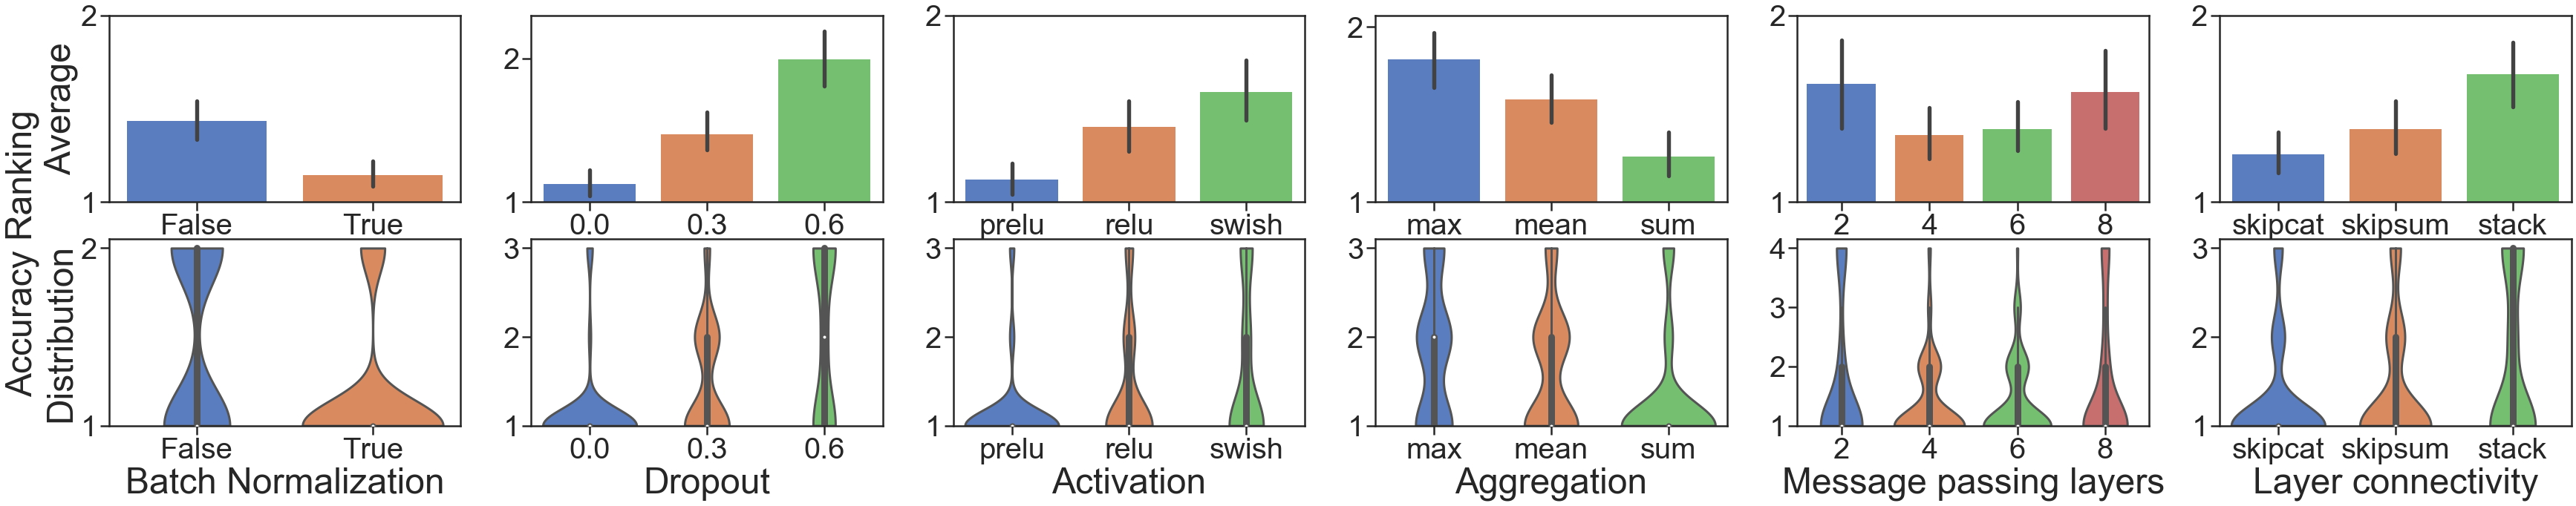

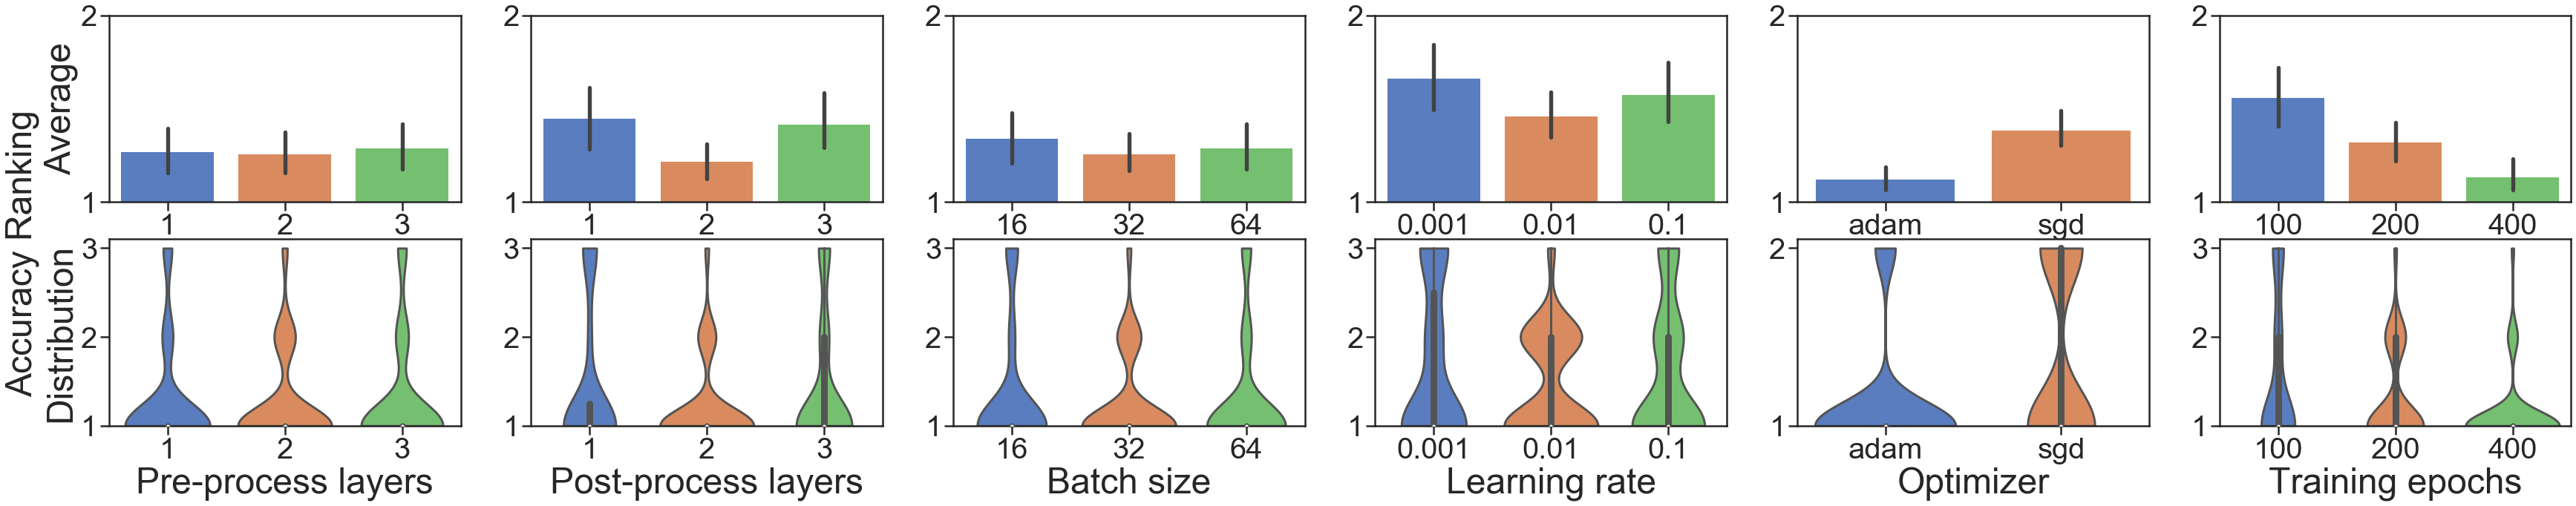

In [18]:
# (1) A general guideline for GNN design
# Trade-off analysis for each design dimension in the design space
# Figure 3 in "Design Space for Graph Neural Networks"
from scipy.stats import rankdata, ttest_ind, f_oneway
from matplotlib.ticker import MaxNLocator

results_file_path = '../run/results/design_v1_grid_round1/agg/val.csv'
df = pd.read_csv(results_file_path)
df['epoch'] += 1
df.replace('skipconcat','skipcat',inplace=True)
df.replace('add','sum',inplace=True)


name_mapping = {'act': 'Activation', 'bn':'Batch Normalization', 'drop':'Dropout', 'agg':'Aggregation',
                'l_mp':'Message passing layers', 'l_pre':'Pre-process layers', 'l_post': 'Post-process layers', 'stage': 'Layer connectivity',
                'lr': 'Learning rate', 'batch':'Batch size', 'optim': 'Optimizer', 'epoch': 'Training epochs'}

column = ['sample', 'format', 'dataset', 'task', 'trans', 'feature', 'label',
       'batch', 'l_pre', 'l_mp', 'l_post', 'stage', 'bn', 'act', 'drop', 'agg',
       'optim', 'lr', 'epoch']

def get_acc(df, name, ax, metric='acc', has_y=True):
    df_selected = df[df['sample']==name].copy()
    df_selected[column] = df_selected[column].fillna('Nan')

    column_temp = copy.deepcopy(column)
    column_temp.remove(name)
    df_pivot = pd.pivot_table(df_selected, values='accuracy', index=column_temp, columns=[name], aggfunc=np.mean)
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(2)
    options = df_pivot.columns.values
        
    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name_mapping[name]:[]}
    
    rank_np = np.zeros((accs_np.shape[0], accs_np.shape[1]))
    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row; (2) rank start with 1 so we minus 1
        rank_base = -row
        med = np.median(rank_base)
        bias = 0.021
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= bias:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping[name]].append(options[j])
            rank_np[i,j]=rank[j]

#     if metric == 'rank_bar':
#         p_value = f_oneway(*[rank_np[:,i] for i in range(rank_np.shape[1])])[1]
#         print(name, p_value, p_value<0.05, p_value<0.05/12)

    ranks_raw = pd.DataFrame(data=ranks_raw)     
    with sns.color_palette("muted"):
        if metric=='acc':
            splot = sns.violinplot(x=name_mapping[name], y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
        elif metric=='rank_bar':
            splot = sns.barplot(x=name_mapping[name], y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Average',fontsize=48)
        elif metric=='rank_violin':
            sns.violinplot(x=name_mapping[name], y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Distribution',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        
for names in [['bn','drop','act','agg','l_mp','stage'], ['l_pre','l_post','batch','lr','optim','epoch']]:
    col = 6
    row = 2
    f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 10))
    
    for j,metric in enumerate(['rank_bar','rank_violin']):
        for i,name in enumerate(names):
            get_acc(df, name, axes[j, i], metric, has_y=i==0)
    f.text(-0.001, 0.5, 'Accuracy Ranking', ha='center', va='center', rotation='vertical', fontsize=48)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
#     f.savefig('figs/{}.png'.format(metric), dpi=150, bbox_inches='tight')
    
    plt.show()

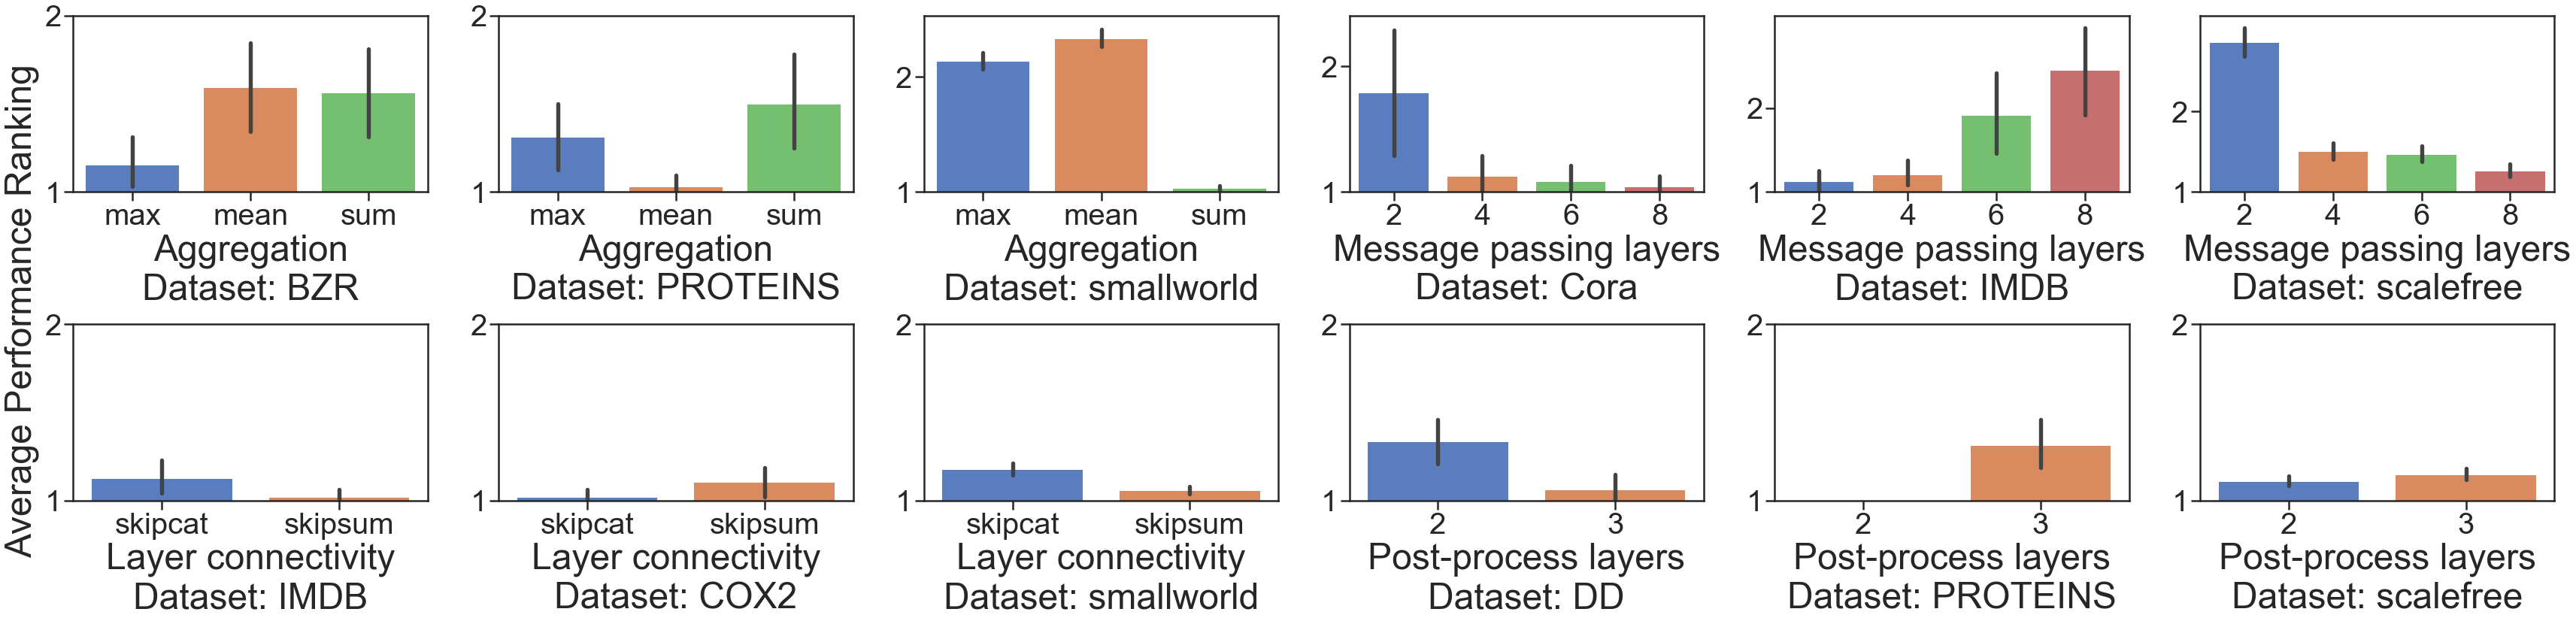

In [19]:
# (2) Explore designs for different tasks
# We show that desirable designs for different tasks are different
# Figure 4 in "Design Space for Graph Neural Networks"
from scipy.stats import rankdata
from matplotlib.ticker import MaxNLocator

results_file_path = '../run/results/design_v2_grid_round2/agg/val.csv'
df = pd.read_csv(results_file_path)
df['epoch'] += 1
df.replace('skipconcat','skipcat',inplace=True)
df.replace('add','sum',inplace=True)


name_mapping = {'act': 'Activation', 'bn':'Batch Normalization', 'drop':'Dropout', 'agg':'Aggregation',
                'l_mp':'Message passing layers', 'l_pre':'Pre-process layers', 'l_post': 'Post-process layers', 'stage': 'Layer connectivity',
                'lr': 'Learning rate', 'batch':'Batch size', 'optim': 'Optimizer', 'epoch': 'Training epochs'}

val_mapping = {'skipconcat':'skipcat', 'TU_BZR':'BZR', 'TU_COX2':'COX2', 'TU_DD':'DD', 'TU_ENZYMES':'ENZYMES',
              'TU_IMDB':'IMDB', 'TU_PROTEINS':'PROTEINS', 'graph_path_len':'path',
               'node_clustering_coefficient':'clustering', 'node_const':'const', 'node_onehot':'onehot',
              'node_pagerank':'pagerank', 'smallworld':'smallworld', 'scalefree':'scalefree', 'Cora':'Cora'}

column = ['format', 'dataset', 'task', 'trans', 'feature', 'label', 'l_pre', 'l_mp', 'l_post', 'stage', 'agg']

def get_acc(df, name, ax, metric='acc', has_y=True, name_d=''):
    df_selected = df[df['dataset']==name_d].copy()

    df_selected[column] = df_selected[column].fillna('Nan')

    column_temp = copy.deepcopy(column)
    column_temp.remove(name)
    df_pivot = pd.pivot_table(df_selected, values='accuracy', index=column_temp, columns=[name], aggfunc=np.mean)
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(2)
    options = df_pivot.columns.values

    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name_mapping[name]:[]}
    
    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row; (2) rank start with 1 so we minus 1
        rank_base = -row
        med = np.median(rank_base)
        bias = 0.011
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= bias:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping[name]].append(options[j])
    

    ranks_raw = pd.DataFrame(data=ranks_raw)     
    with sns.color_palette("muted"):
        if metric=='acc':
            splot = sns.violinplot(x=name_mapping[name], y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
        elif metric=='rank_bar':
            splot = sns.barplot(x=name_mapping[name], y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('{}\nDataset: {}'.format(name_mapping[name],val_mapping[name_d]),fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Avg. Ranking',fontsize=48)
        elif metric=='rank_violin':
            sns.violinplot(x=name_mapping[name], y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_ylim(bottom=1)
#             ax.set_yticks([1,2])
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Distribution',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(40)

col = 6
row = 2
f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 12))
i = 0
for name, name_d in [['agg','TU_BZR'], ['agg','TU_PROTEINS'], ['agg','smallworld'], 
                ['l_mp','Cora'], ['l_mp','TU_IMDB'], ['l_mp','scalefree']]:
    get_acc(df, name, axes[0, i], metric='rank_bar', name_d=name_d, has_y=False)
    i += 1

i = 0
for name, name_d in [['stage','TU_IMDB'], ['stage','TU_COX2'], ['stage','smallworld'], 
                ['l_post','TU_DD'], ['l_post','TU_PROTEINS'], ['l_post','scalefree']]:
    get_acc(df, name, axes[1, i], metric='rank_bar', name_d=name_d, has_y=False)
    i += 1

f.text(-0.001, 0.5, 'Average Performance Ranking', ha='center', va='center', rotation='vertical', fontsize=48)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.75)        

# f.savefig('figs/ranktask.png', dpi=150, bbox_inches='tight')

plt.show()

        

Best performance in each task


best performance  \
task        dataset         feature    label                          
Node-level  AmazonComputers N/A        N/A                   0.9164   
            AmazonPhoto     N/A        N/A                   0.9614   
            CiteSeer        N/A        N/A                   0.7448   
            CoauthorCS      N/A        N/A                   0.9519   
            CoauthorPhysics N/A        N/A                   0.9676   
            Cora            N/A        N/A                   0.8846   
Graph-level PROTEINS        N/A        N/A                   0.7394   
            BZR             N/A        N/A                   0.8930   
            COX2            N/A        N/A                   0.8085   
            DD              N/A        N/A                   0.7514   
            ENZYMES         N/A        N/A                   0.6083   
            IMDB            N/A        N/A                   0.4778   
            scalefree       clustering path                  0.9039   
                            const      path                  0.8654   
                            onehot     path                  0.7756   
                            pagerank   path                  0.8397   
            smallworld      clustering path                  0.9231   
                            const      path                  0.8654   
                            onehot     path                  0.6987   
                            pagerank   path                  0.8526   
Node-level  scalefree       clustering pagerank              0.9767   
                            const      clustering            0.7115   
                                       pagerank              0.9776   
                            onehot     clustering            0.6840   
                                       pagerank              0.9731   
                            pagerank   clustering            0.7183   
            smallworld      clustering pagerank              0.9573   
                            const      clustering            0.6066   
                                       pagerank              0.9533   
                            onehot     clustering            0.5998   
                                       pagerank              0.9500   
                            pagerank   clustering            0.6183   

                                                                     best design  
task        dataset         feature    label                                      
Node-level  AmazonComputers N/A        N/A          (1, 2, 2, skipcat, max, 400)  
            AmazonPhoto     N/A        N/A          (2, 2, 2, skipcat, max, 400)  
            CiteSeer        N/A        N/A         (2, 6, 2, skipcat, mean, 400)  
            CoauthorCS      N/A        N/A         (1, 4, 3, skipcat, mean, 400)  
            CoauthorPhysics N/A        N/A          (1, 4, 2, skipcat, max, 400)  
            Cora            N/A        N/A         (1, 8, 2, skipcat, mean, 400)  
Graph-level PROTEINS        N/A        N/A         (1, 8, 2, skipcat, mean, 400)  
            BZR             N/A        N/A         (1, 8, 2, skipcat, mean, 400)  
            COX2            N/A        N/A          (1, 6, 2, skipsum, max, 400)  
            DD              N/A        N/A          (2, 2, 3, skipsum, add, 400)  
            ENZYMES         N/A        N/A          (2, 4, 3, skipsum, add, 400)  
            IMDB            N/A        N/A          (2, 8, 2, skipsum, add, 400)  
            scalefree       clustering path         (2, 2, 2, skipsum, add, 400)  
                            const      path         (1, 8, 3, skipcat, add, 400)  
                            onehot     path         (1, 4, 3, skipsum, add, 400)  
                            pagerank   path         (1, 8, 3, skipcat, add, 400)  
            smallworld      clustering path         (1, 4, 2, skipcat, add, 400)  
                            const      path         (1, 8, 

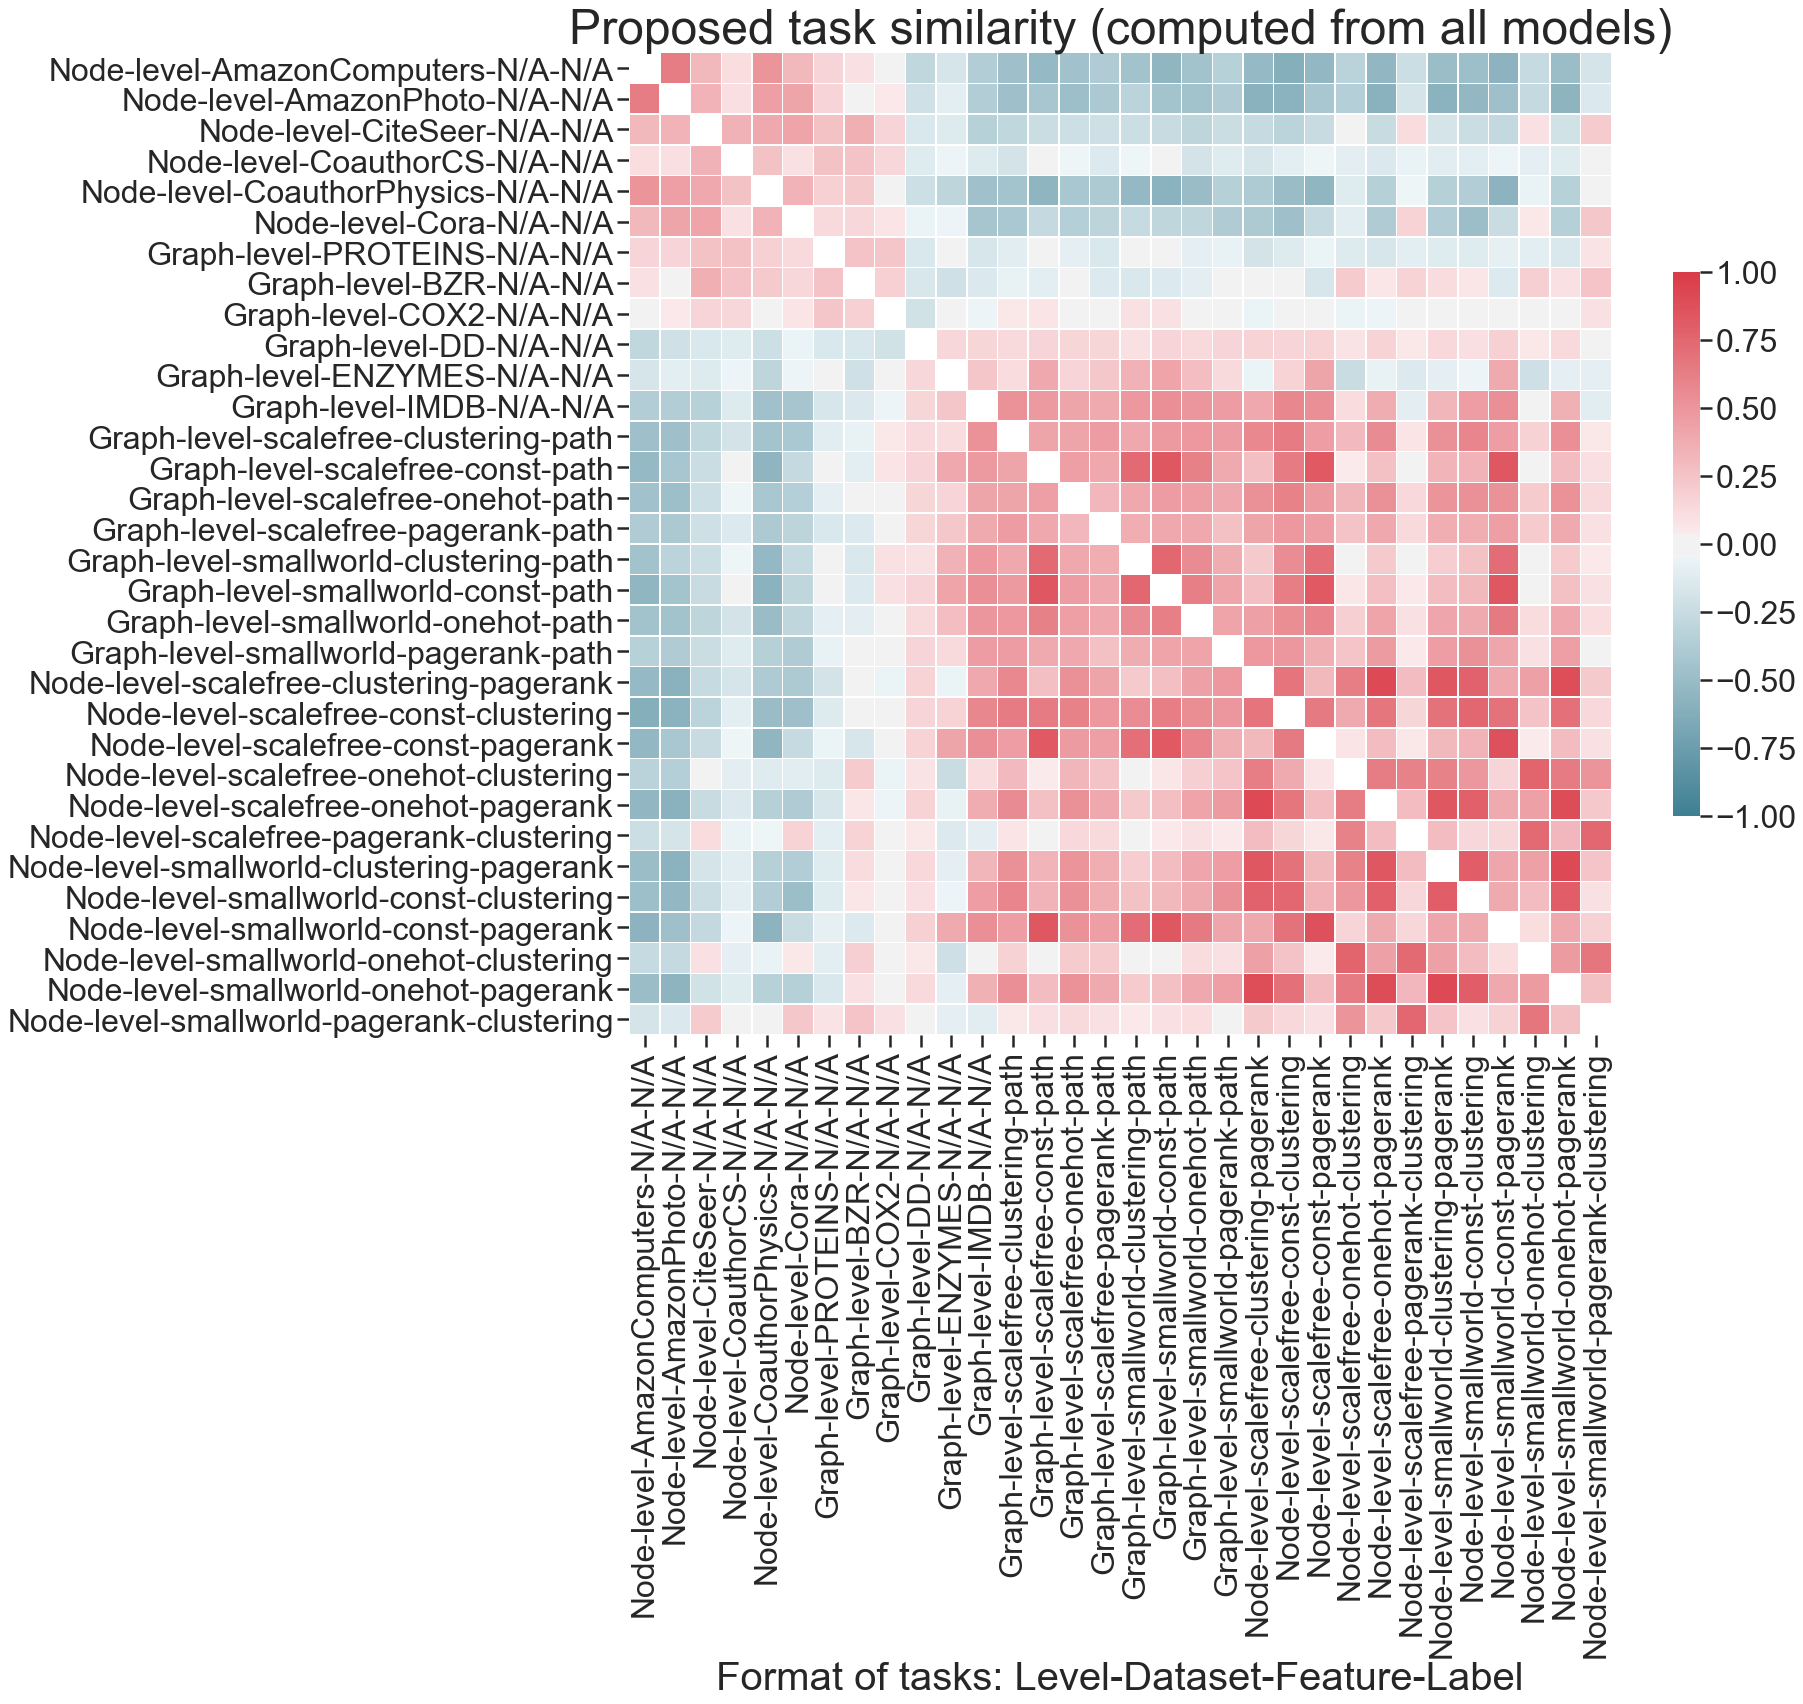

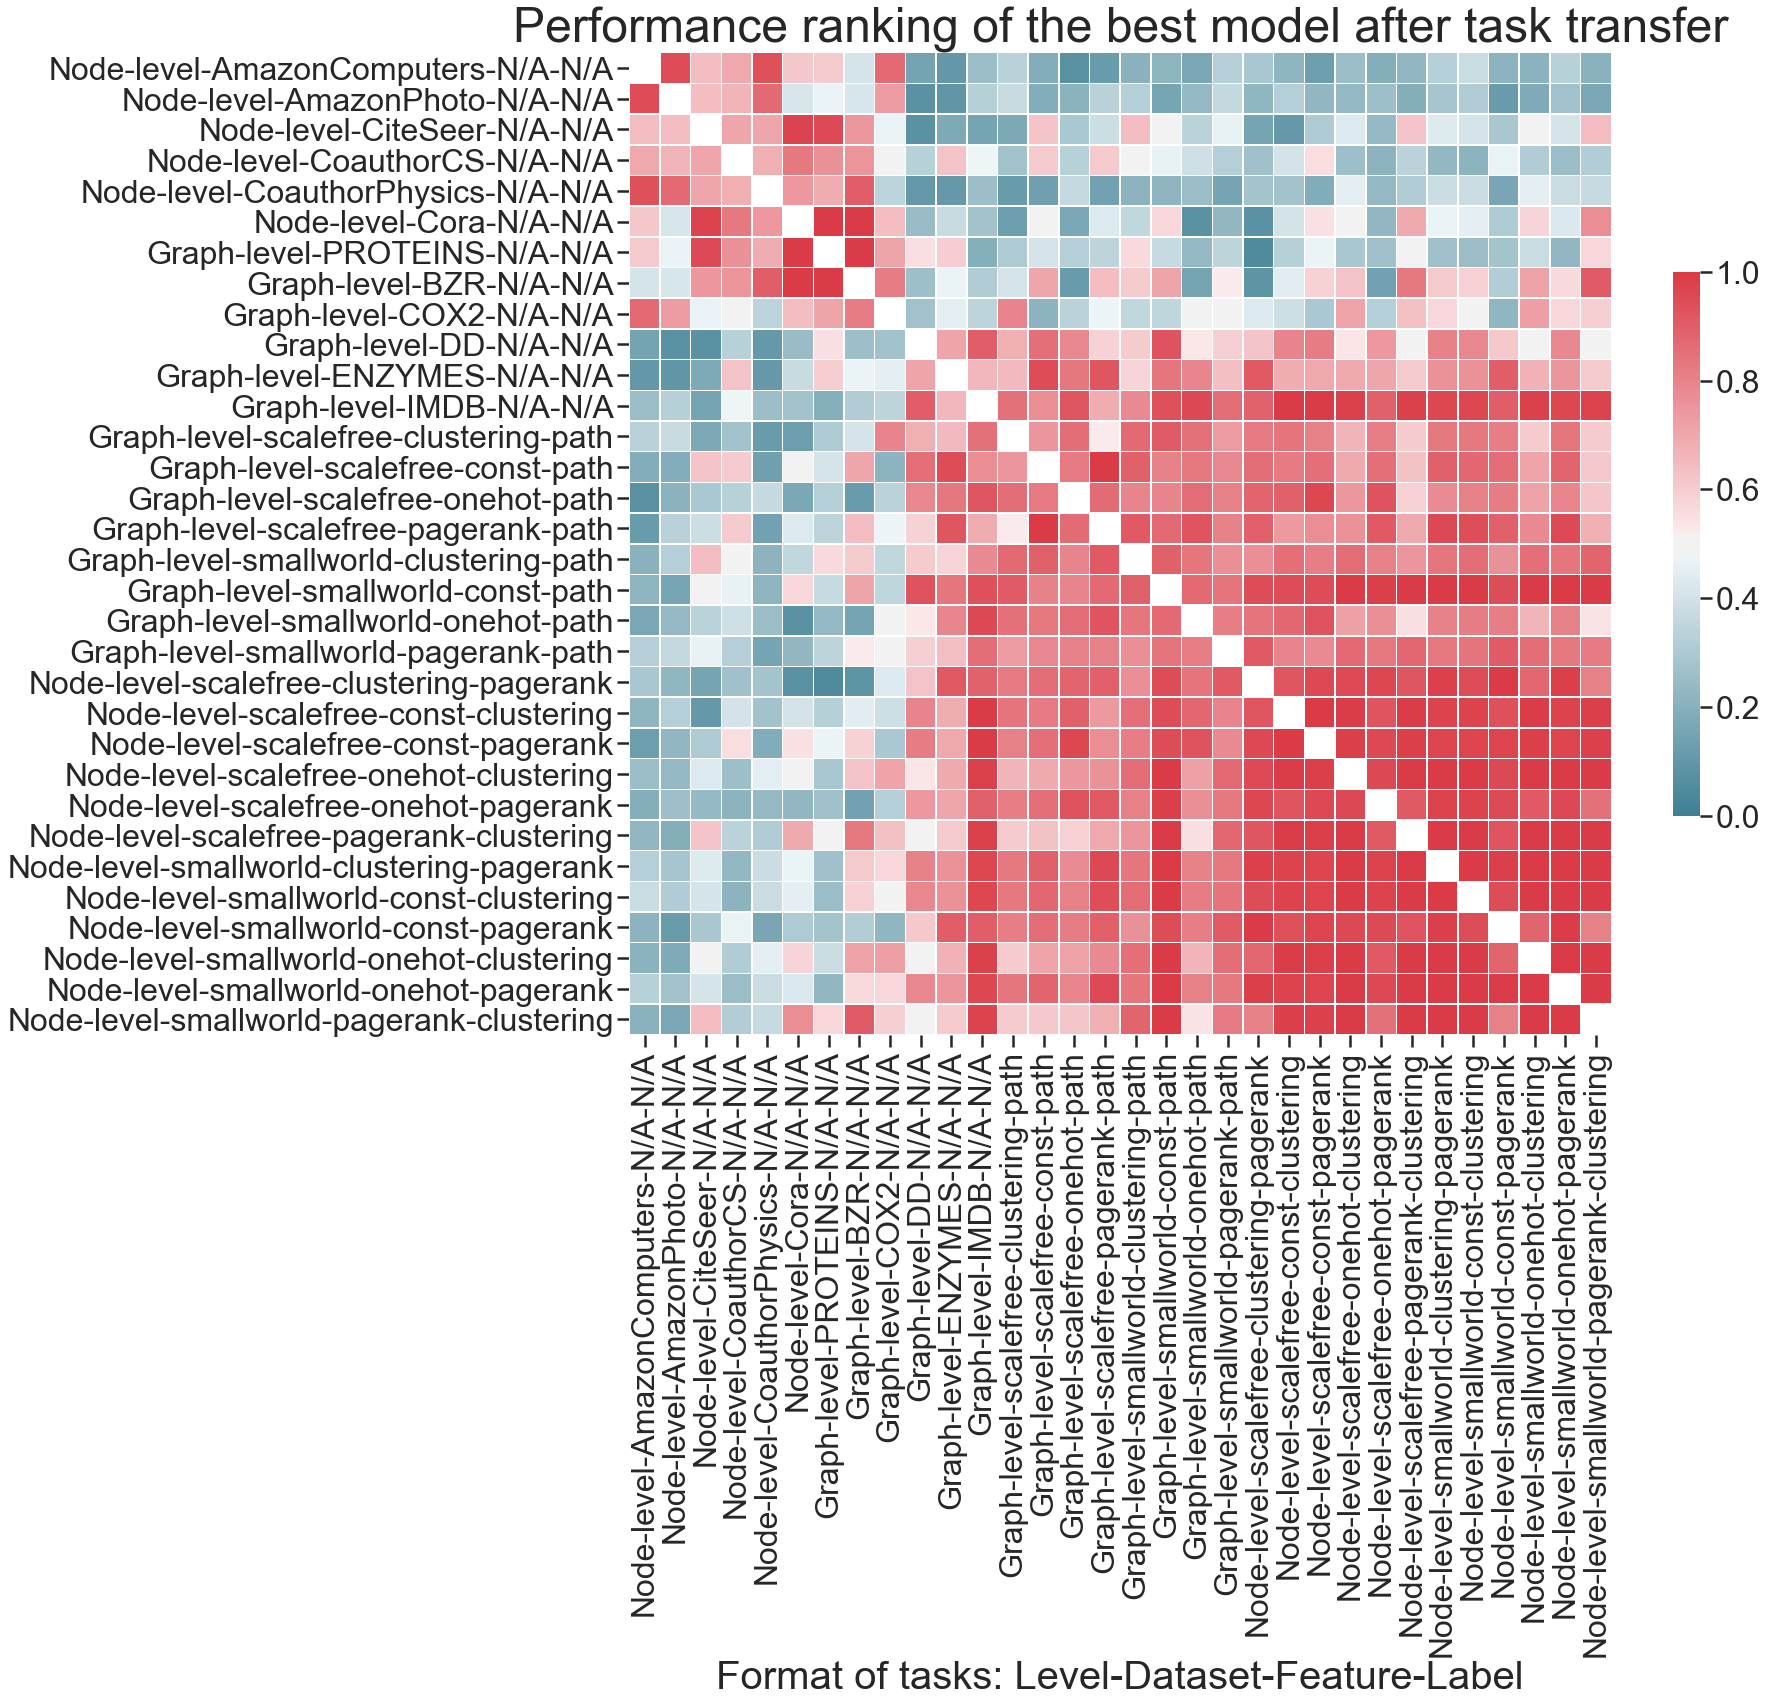

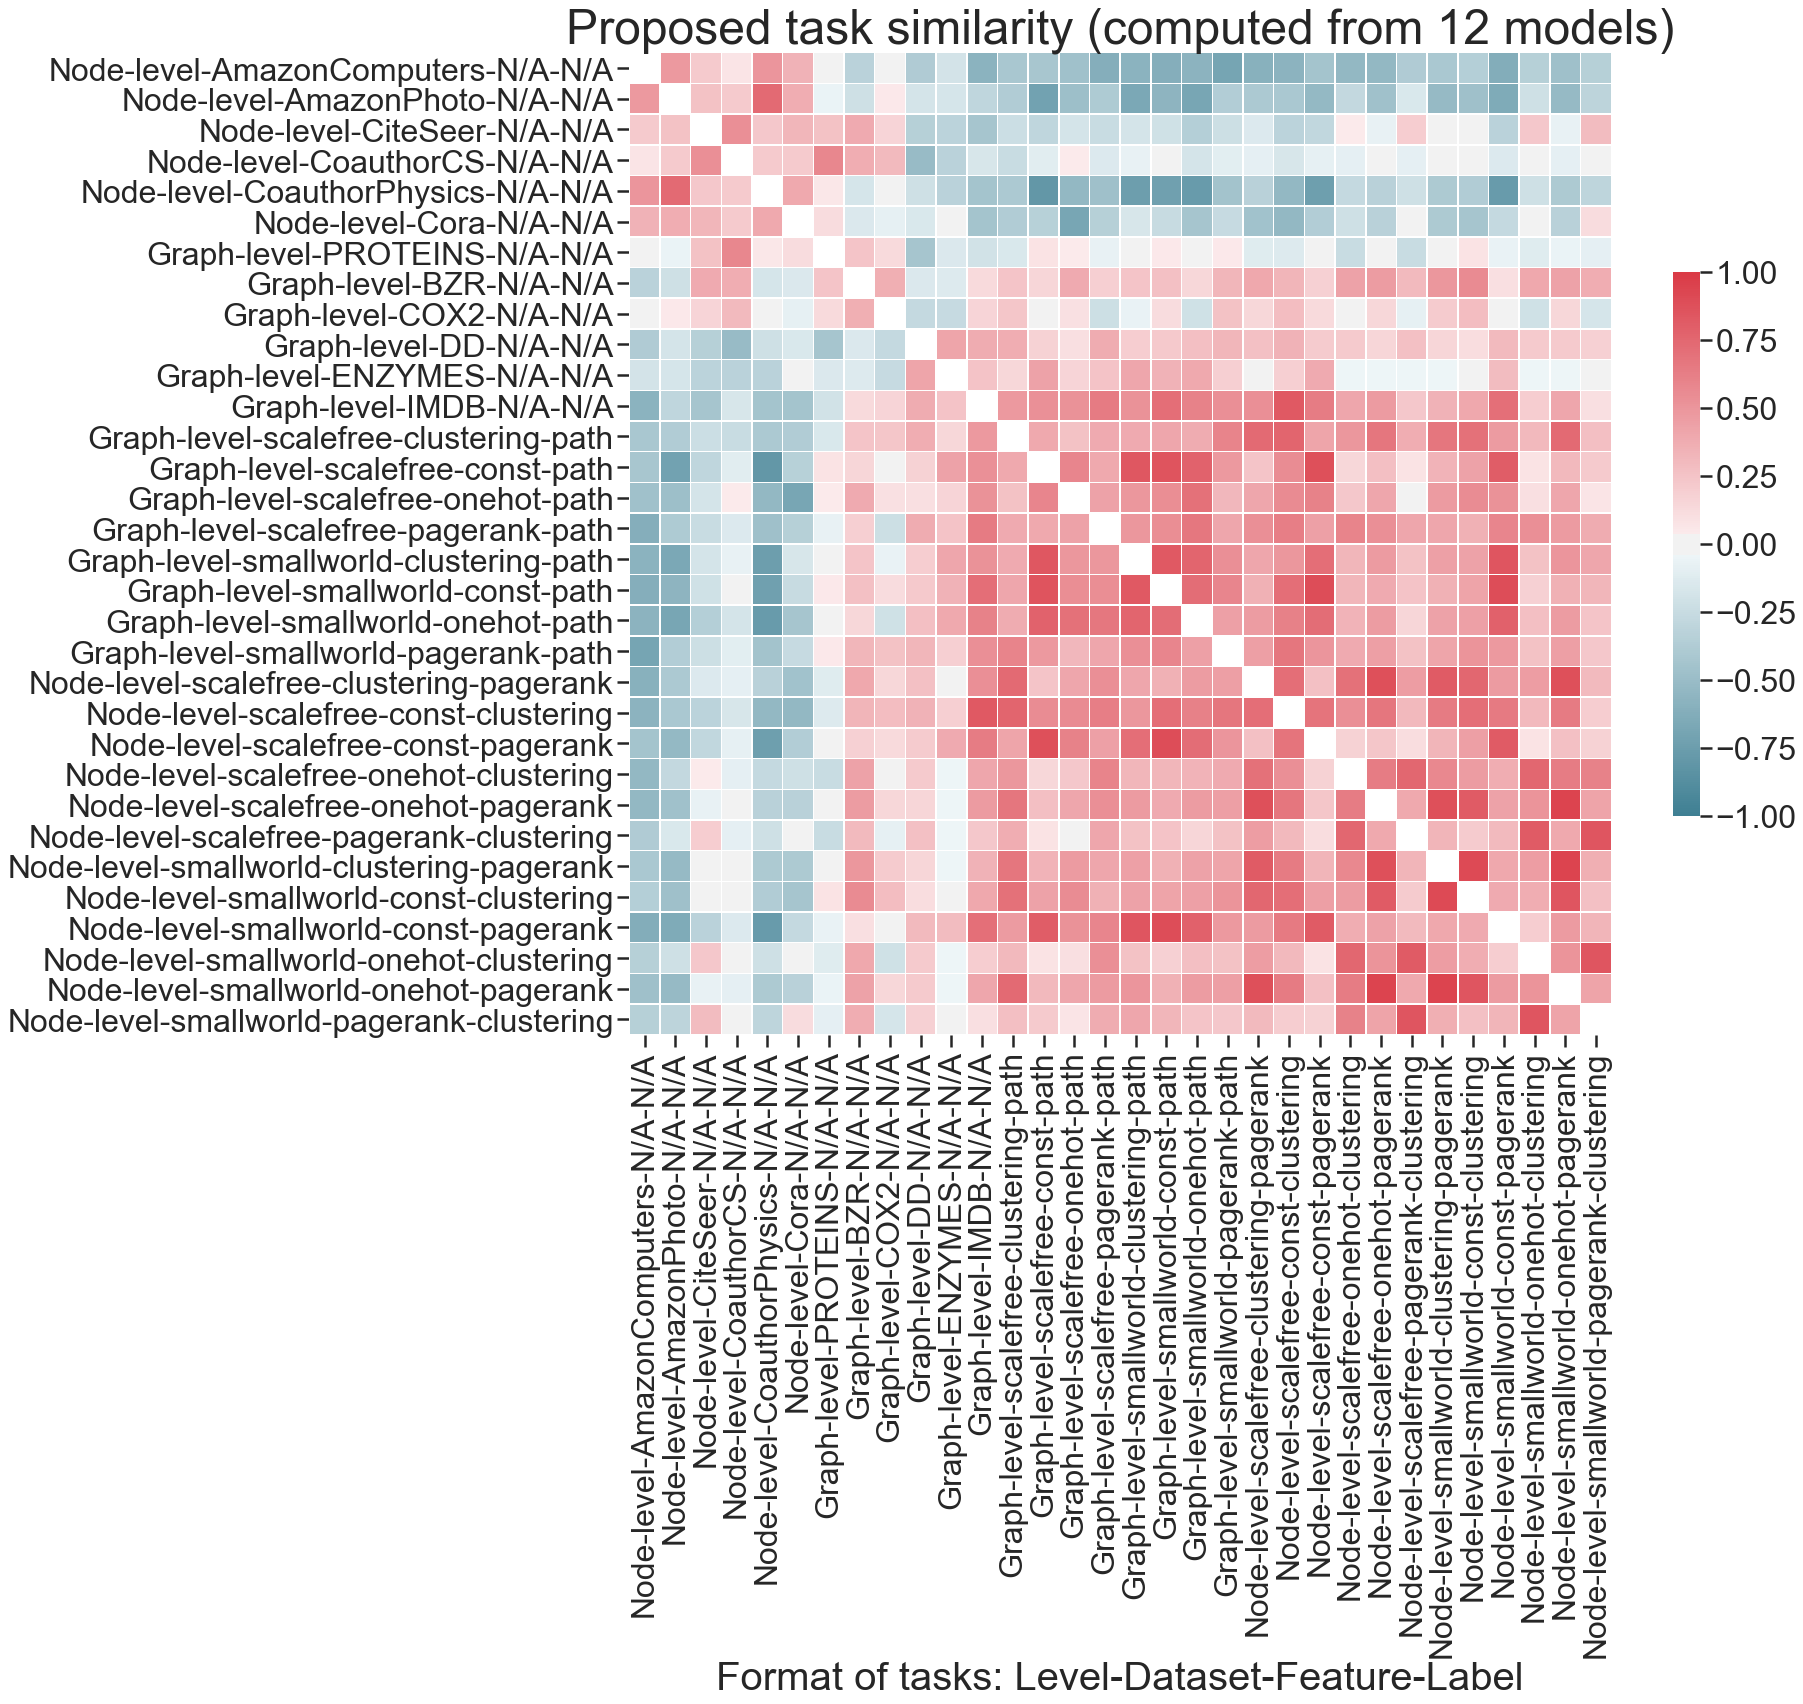

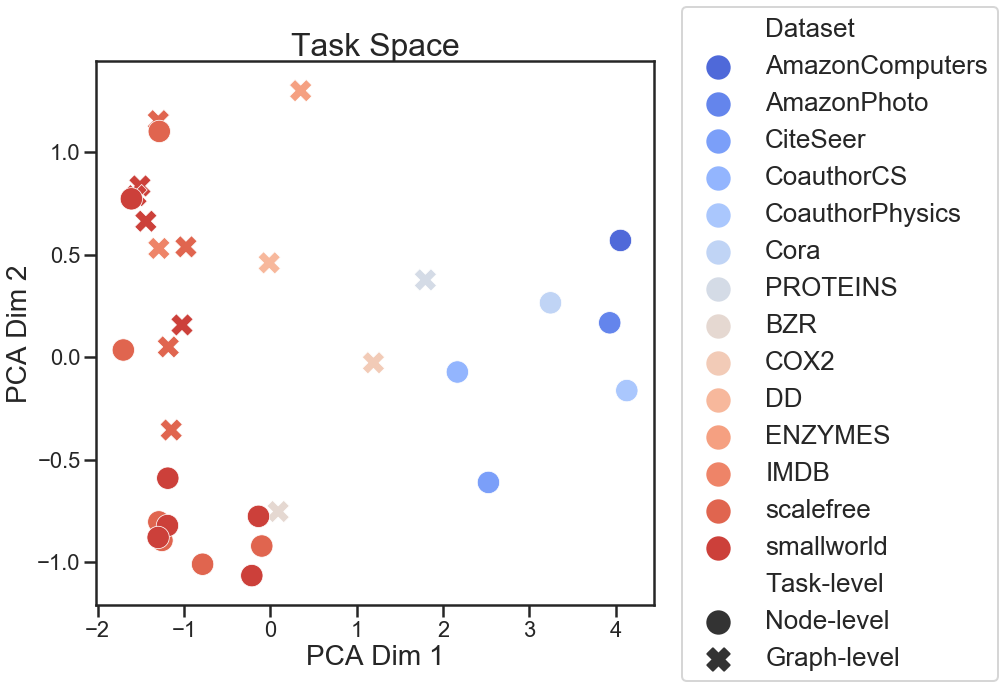

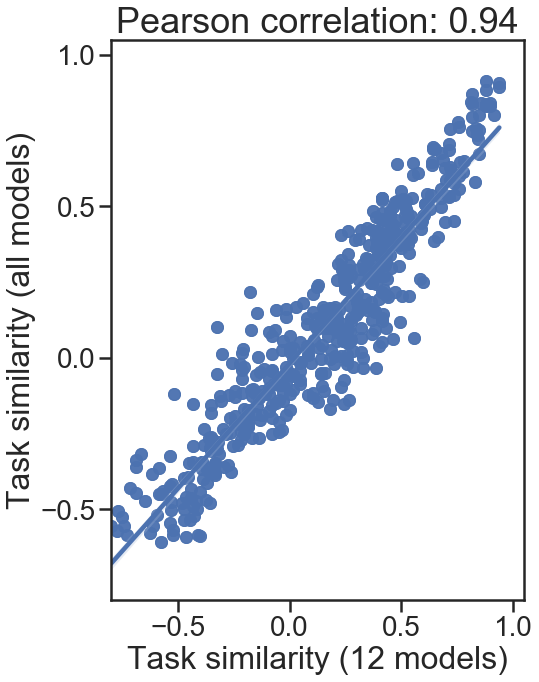

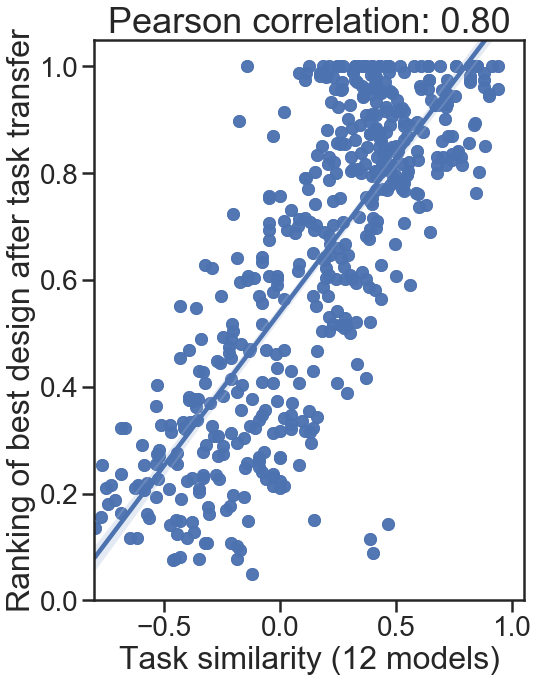

In [20]:
# (3) Explore the task space of GNN, Transfer best designs across tasks
# We show that the proposed task space is meaningful
# Notably, best design in one task can be transferred to other tasks with high similarity
# Figure 5 in "Design Space for Graph Neural Networks"
from scipy.stats import rankdata
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def best_in_others_rank(a, b):
    a_best = np.argmax(a)
    b_rank = rankdata(b)[a_best] / len(b)
    b_best = np.argmax(b)
    a_rank = rankdata(a)[b_best] / len(a)
    return (a_rank+b_rank)/2

def plot_corr(corr, name, vmin=-1, vmax=1, title=''):
    mask = np.identity(corr.shape[0], dtype=np.bool)
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(22, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=vmin, vmax=vmax, center=(vmax+vmin)/2,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title, fontsize=48)
    ax.set_xlabel('Format of tasks: Level-Dataset-Feature-Label',fontsize=40)
    ax.set_ylabel('')
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(32)
    for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(32)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=32)
#     plt.savefig('figs/{}.png'.format(name), dpi=100, bbox_inches='tight')
    plt.show()

results_file_path = '../run/results/design_v2_grid_round2/agg/val.csv'
df = pd.read_csv(results_file_path)
df['epoch'] += 1

val_mapping = {'skipconcat':'skipcat', 'TU_BZR':'BZR', 'TU_COX2':'COX2', 'TU_DD':'DD', 'TU_ENZYMES':'ENZYMES',
              'TU_IMDB':'IMDB', 'TU_PROTEINS':'PROTEINS', 'graph_path_len':'path',
               'node_clustering_coefficient':'clustering', 'node_const':'const', 'node_onehot':'onehot',
              'node_pagerank':'pagerank', 'node':'Node-level', 'graph':'Graph-level'}

for key, val in val_mapping.items():
    df.replace(key,val,inplace=True)
df = df.fillna('N/A')
# display(df)
task_names = ['task','dataset', 'feature', 'label']

model_names = ['l_pre', 'l_mp', 'l_post', 'stage', 'agg','epoch']

df_pivot = pd.pivot_table(df, values='accuracy', index=model_names, columns=task_names, aggfunc=np.mean)
cols = df_pivot.columns.tolist()
cols_new = cols[14:20]+cols[:14]+cols[20:]
cols_new = cols_new[:8]+cols_new[11:12]+cols_new[8:11]+cols_new[12:]
cols_new = cols_new[:6]+cols_new[8:9]+cols_new[6:8]+cols_new[9:]
df_pivot = df_pivot[cols_new]


df_best = df_pivot.max(axis=0).copy().to_frame('best performance')
df_id = df_pivot.idxmax(axis=0).to_frame('best design')
df_concat = pd.concat([df_best, df_id], axis=1)
print('Best performance in each task')
display(df_concat)

corr = df_pivot.corr(method='kendall')
plot_corr(corr, 'corr_all', title='Proposed task similarity (computed from all models)')


corr_rank = df_pivot.corr(method=best_in_others_rank)
plot_corr(corr_rank, name='corr_rank_all', vmin=0, vmax=1, title='Performance ranking of the best model after task transfer')



df_pivot_agg = pd.pivot_table(df, values='accuracy', index=model_names, aggfunc=np.mean)
df_pivot_agg = df_pivot_agg.sort_values('accuracy', ascending=False)


for K in [12]:
    model_ids = np.linspace(0,len(df_pivot_agg)-1,K).astype(int)
    select_index = df_pivot_agg.index[model_ids]
    df_pivot_select = df_pivot.loc[select_index]

    corr_select = df_pivot_select.corr(method='kendall')
    plot_corr(corr_select, 'corr_{}'.format(K), title='Proposed task similarity (computed from 12 models)')
    
corr_emb = corr_select.copy()
pca = PCA(n_components=2)
emb = pca.fit_transform(corr_emb)


corr_emb['axis0'] = emb[:,0]
corr_emb['axis1'] = emb[:,1]
corr_emb = corr_emb.reset_index()
corr_emb['Task format: Level-Dataset'] = corr_emb[['task', 'dataset']].agg('-'.join, axis=1)
corr_emb['Dataset'] = corr_emb['dataset']
corr_emb['Task-level'] = corr_emb['task']


with sns.color_palette("coolwarm", 14):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='axis0',y='axis1',style='Task-level',hue='Dataset',data=corr_emb, s=500)
    lgnd = plt.legend(bbox_to_anchor=(1.05, 1.1), loc=2, borderaxespad=0., prop={'size': 26})
    for i in range(18):
        lgnd.legendHandles[i]._sizes = [500]
    plt.xlabel('PCA Dim 1', fontsize=28)
    plt.ylabel('PCA Dim 2', fontsize=28)
    plt.title('Task Space', fontsize=32)
#     plt.savefig('figs/task_space.png', dpi=150, bbox_inches='tight')
    plt.show()


f = plt.figure(figsize=(8, 10))

a = corr_select.values
x = a[~np.eye(a.shape[0],dtype=bool)].flatten()
a = corr.values
y = a[~np.eye(a.shape[0],dtype=bool)].flatten()


ax = plt.gca()

sns.regplot(x, y, ax=ax)
ax.set_title('Pearson correlation: {}'.format(pearsonr(x,y)[0].round(2)), fontsize=36)
ax.set_xlabel('Task similarity (12 models)', fontsize=32)
ax.set_ylabel('Task similarity (all models)', fontsize=32)
ax.set_xlim([-0.8, 1.05])
ax.set_ylim([-0.8, 1.05])
ax.set_xticks([-0.5,0,0.5,1])
ax.set_yticks([-0.5,0,0.5,1])
ax.tick_params(axis='both', which='major', labelsize=28)

plt.tight_layout()
# plt.savefig('figs/corr_sim12_simall.png', dpi=150, bbox_inches='tight')
plt.show()


f = plt.figure(figsize=(8, 10))

a = corr_select.values
x = a[~np.eye(a.shape[0],dtype=bool)].flatten()
a = corr_rank.values
y = a[~np.eye(a.shape[0],dtype=bool)].flatten()

ax = plt.gca()
sns.regplot(x, y, ax=ax)
ax.set_title('Pearson correlation: 0.80', fontsize=36)
ax.set_xlabel('Task similarity (12 models)', fontsize=32)
ax.set_ylabel('Ranking of best design after task transfer', fontsize=32)
ax.set_xlim([-0.8, 1.05])
ax.set_ylim([0, 1.05])
ax.tick_params(axis='both', which='major', labelsize=28)

plt.tight_layout()
# plt.savefig('figs/corr_sim12_rank.png', dpi=150, bbox_inches='tight')
plt.show()



Best performance in each task


best performance  \
task  dataset         feature    label                          
graph BZR             N/A        N/A                   0.8930   
      COX2            N/A        N/A                   0.8085   
      DD              N/A        N/A                   0.7514   
      ENZYMES         N/A        N/A                   0.6083   
      IMDB            N/A        N/A                   0.4778   
      PROTEINS        N/A        N/A                   0.7394   
      ogbg            N/A        N/A                   0.7915   
      scalefree       clustering path                  0.9039   
                      const      path                  0.8654   
                      onehot     path                  0.7756   
                      pagerank   path                  0.8397   
      smallworld      clustering path                  0.9231   
                      const      path                  0.8654   
                      onehot     path                  0.6987   
                      pagerank   path                  0.8526   
node  AmazonComputers N/A        N/A                   0.9164   
      AmazonPhoto     N/A        N/A                   0.9614   
      CiteSeer        N/A        N/A                   0.7448   
      CoauthorCS      N/A        N/A                   0.9519   
      CoauthorPhysics N/A        N/A                   0.9676   
      Cora            N/A        N/A                   0.8846   
      scalefree       clustering pagerank              0.9767   
                      const      clustering            0.7115   
                                 pagerank              0.9776   
                      onehot     clustering            0.6840   
                                 pagerank              0.9731   
                      pagerank   clustering            0.7183   
      smallworld      clustering pagerank              0.9573   
                      const      clustering            0.6066   
                                 pagerank              0.9533   
                      onehot     clustering            0.5998   
                                 pagerank              0.9500   
                      pagerank   clustering            0.6183   

                                                          best design  
task  dataset         feature    label                                 
graph BZR             N/A        N/A         (1, 8, 2, skipcat, mean)  
      COX2            N/A        N/A          (1, 6, 2, skipsum, max)  
      DD              N/A        N/A          (2, 2, 3, skipsum, add)  
      ENZYMES         N/A        N/A          (2, 4, 3, skipsum, add)  
      IMDB            N/A        N/A          (2, 8, 2, skipsum, add)  
      PROTEINS        N/A        N/A         (1, 8, 2, skipcat, mean)  
      ogbg            N/A        N/A          (2, 6, 3, skipcat, add)  
      scalefree       clustering path         (2, 2, 2, skipsum, add)  
                      const      path         (1, 8, 3, skipcat, add)  
                      onehot     path         (1, 4, 3, skipsum, add)  
                      pagerank   path         (1, 8, 3, skipcat, add)  
      smallworld      clustering path         (1, 4, 2, skipcat, add)  
                      const      path         (1, 8, 2, skipsum, add)  
                      onehot     path         (1, 4, 3, skipcat, add)  
                      pagerank   path         (1, 4, 2, skipsum, add)  
node  AmazonComputers N/A        N/A          (1, 2, 2, skipcat, max)  
      AmazonPhoto     N/A        N/A          (2, 2, 2, skipcat, max)  
      CiteSeer        N/A        N/A         (2, 6, 2, skipcat, mean)  
      CoauthorCS      N/A        N/A         (1, 4, 3, skipcat, mean)  
      CoauthorPhysics N/A        N/A          (1, 4, 2, skipcat, max)  
      Cora            N/A        N/A         (1, 8, 2, skipcat, mean)  
      scalefree       clustering pagerank     (2, 8, 3, skipsum, add)  
                      const      clusteri

Task similarity computed from all models, computed from 12 models, and model ranking after task transfer


task_sim_allmodel  \
task  dataset         feature    label                           
graph BZR             N/A        N/A                  0.066797   
      COX2            N/A        N/A                  0.011046   
      DD              N/A        N/A                  0.026779   
      ENZYMES         N/A        N/A                 -0.101608   
      IMDB            N/A        N/A                  0.073731   
      PROTEINS        N/A        N/A                 -0.039087   
      ogbg            N/A        N/A                  1.000000   
      scalefree       clustering path                 0.045085   
                      const      path                 0.001219   
                      onehot     path                 0.020336   
                      pagerank   path                -0.053446   
      smallworld      clustering path                -0.039105   
                      const      path                -0.008738   
                      onehot     path                -0.036200   
                      pagerank   path                 0.060938   
node  AmazonComputers N/A        N/A                 -0.063394   
      AmazonPhoto     N/A        N/A                 -0.095574   
      CiteSeer        N/A        N/A                 -0.115313   
      CoauthorCS      N/A        N/A                  0.057534   
      CoauthorPhysics N/A        N/A                 -0.059498   
      Cora            N/A        N/A                 -0.047824   
      scalefree       clustering pagerank             0.067208   
                      const      clustering           0.040145   
                                 pagerank             0.003045   
                      onehot     clustering           0.040189   
                                 pagerank             0.065876   
                      pagerank   clustering           0.004832   
      smallworld      clustering pagerank             0.061032   
                      const      clustering           0.063130   
                                 pagerank             0.009597   
                      onehot     clustering           0.006147   
                                 pagerank             0.075733   
                      pagerank   clustering          -0.010322   

                                             task_sim_12model  \
task  dataset         feature    label                          
graph BZR             N/A        N/A                 0.204883   
      COX2            N/A        N/A                 0.076338   
      DD              N/A        N/A                 0.303030   
      ENZYMES         N/A        N/A                 0.108556   
      IMDB            N/A        N/A                 0.503831   
      PROTEINS        N/A        N/A                -0.259550   
      ogbg            N/A        N/A                 1.000000   
      scalefree       clustering path                0.061546   
                      const      path                0.472812   
                      onehot     path                0.375183   
                      pagerank   path                0.351155   
      smallworld      clustering path                0.454545   
                      const      path                0.456514   
                      onehot     path                0.473296   
                      pagerank   path                0.061546   
node  AmazonComputers N/A        N/A                -0.515152   
      AmazonPhoto     N/A        N/A                -0.454545   
      CiteSeer        N/A        N/A                -0.351155   
      CoauthorCS      N/A        N/A                -0.151515   
      CoauthorPhysics N/A        N/A                -0.606061   
      Cora            N/A        N/A                -0.424242   
      scalefree       clustering pagerank            0.303030   
                      const      clustering          0.532132   
                                 pagerank            0.440204   
                      onehot     clustering 

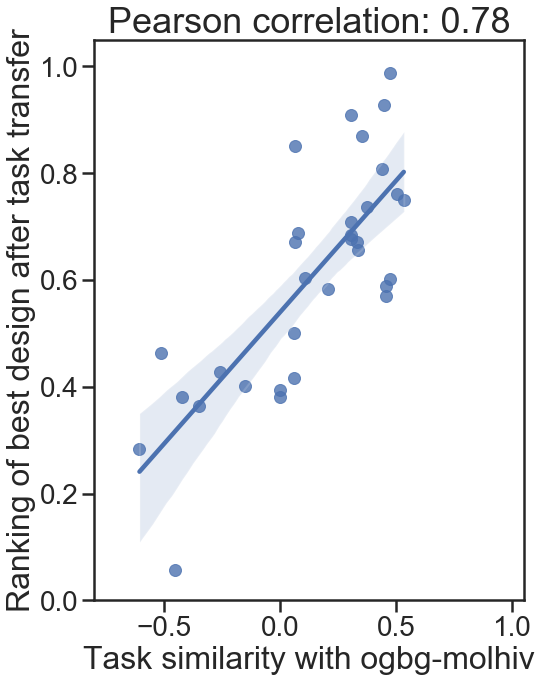

In [21]:
# (4) Case study for OGB
# The task similarity can be used to guide transferring best designs to OGB
# without redoing grid search
# Figure 5 in "Design Space for Graph Neural Networks"

from scipy.stats import rankdata
from scipy.stats import pearsonr

def best_in_others_rank(a, b):
    a_best = np.argmax(a)
    b_rank = rankdata(b)[a_best] / len(b)
    b_best = np.argmax(b)
    a_rank = rankdata(a)[b_best] / len(a)
    return (a_rank+b_rank)/2
      

def plot_corr(corr, name, vmin=-1, vmax=1, title=''):
    mask = np.identity(corr.shape[0], dtype=np.bool)
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(22, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=vmin, vmax=vmax, center=(vmax+vmin)/2,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title, fontsize=48)
    ax.set_xlabel('Format of tasks: Level-Dataset-Feature-Label',fontsize=40)
    ax.set_ylabel('')
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(32)
    for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(32)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=32)
    plt.show()

results_file_path = '../run/results/design_v2_grid_round2/agg/val.csv'
results_ogb_file_path = '../run/results/design_v2ogb_grid_round2ogb/agg/test.csv'
df = pd.read_csv(results_file_path)
df_ogb = pd.read_csv(results_ogb_file_path)

df_ogb['accuracy'] = np.where(df_ogb['auc'].isnull(), df_ogb['accuracy'], df_ogb['auc'])


df = df.append(df_ogb, ignore_index=True)

df['epoch'] += 1

val_mapping = {'skipconcat':'skipcat', 'TU_BZR':'BZR', 'TU_COX2':'COX2', 'TU_DD':'DD', 'TU_ENZYMES':'ENZYMES',
              'TU_IMDB':'IMDB', 'TU_PROTEINS':'PROTEINS', 'graph_path_len':'path',
               'node_clustering_coefficient':'clustering', 'node_const':'const', 'node_onehot':'onehot',
              'node_pagerank':'pagerank'}

for key, val in val_mapping.items():
    df.replace(key,val,inplace=True)
df = df.fillna('N/A')
task_names = ['task','dataset', 'feature', 'label']

model_names = ['l_pre', 'l_mp', 'l_post', 'stage', 'agg']

df_pivot = pd.pivot_table(df, values='accuracy', index=model_names, columns=task_names, aggfunc=np.mean)

df_best = df_pivot.max(axis=0).copy().to_frame('best performance')
df_id = df_pivot.idxmax(axis=0).to_frame('best design')
df_concat = pd.concat([df_best, df_id], axis=1)
print('Best performance in each task')
display(df_concat)

corr = df_pivot.corr(method='kendall')
# iloc[6] gets ogb results
task_sim_allmodel = corr.iloc[6].sort_values(ascending=False).to_frame('task_sim_allmodel')

corr_rank = df_pivot.corr(method=best_in_others_rank)
rank_after_transfer = corr_rank.iloc[6].sort_values(ascending=False).to_frame('rank_after_transfer')

df_pivot_agg = pd.pivot_table(df, values='accuracy', index=model_names, aggfunc=np.mean)
df_pivot_agg = df_pivot_agg.sort_values('accuracy', ascending=False)

for K in [12]:
    model_ids = np.linspace(0,len(df_pivot_agg)-1,K).astype(int)
    select_index = df_pivot_agg.index[model_ids]
    df_pivot_select = df_pivot.loc[select_index]

    corr_select = df_pivot_select.corr(method='kendall')
    task_sim_12model = corr_select.iloc[6].sort_values(ascending=False).to_frame('task_sim_12model')

print('Task similarity computed from all models, computed from 12 models, and model ranking after task transfer')
df_sim = pd.concat([task_sim_allmodel, task_sim_12model, rank_after_transfer], axis=1)
display(df_sim)
    

f = plt.figure(figsize=(8, 10))

x = np.delete(corr_select.iloc[6].values, 6)
y = np.delete(corr_rank.iloc[6].values, 6)

ax = plt.gca()
sns.regplot(x, y, ax=ax)
ax.set_title('Pearson correlation: {}'.format(pearsonr(x,y)[0].round(2)), fontsize=36)
ax.set_xlabel('Task similarity with ogbg-molhiv', fontsize=32)
ax.set_ylabel('Ranking of best design after task transfer', fontsize=32)
ax.set_xlim([-0.8, 1.05])
ax.set_ylim([0, 1.05])
ax.tick_params(axis='both', which='major', labelsize=28)


plt.tight_layout()
# plt.savefig('figs/corr_sim_ogb.png', dpi=150, bbox_inches='tight')
plt.show()



In [ ]:
# (5 Appendix) Explore the task space of GNN, Transfer best designs across tasks
# (Added link prediction results)
# We show that the proposed task space is meaningful
# Notably, best design in one task can be transferred to other tasks with high similarity
# Appendix Figure in "Design Space for Graph Neural Networks"

from scipy.stats import rankdata
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def best_in_others_rank(a, b):
    a_best = np.argmax(a)
    b_rank = rankdata(b)[a_best] / len(b)
    b_best = np.argmax(b)
    a_rank = rankdata(a)[b_best] / len(a)
    return (a_rank+b_rank)/2

def plot_corr(corr, name, vmin=-1, vmax=1, title=''):
    mask = np.identity(corr.shape[0], dtype=np.bool)
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(22, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=vmin, vmax=vmax, center=(vmax+vmin)/2,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title, fontsize=48)
    ax.set_xlabel('Format of tasks: Level-Dataset-Feature-Label',fontsize=40)
    ax.set_ylabel('')
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(32)
    for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(32)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=32)
#     plt.savefig('figs/{}.png'.format(name), dpi=100, bbox_inches='tight')
    plt.show()

results_file_path = '../run/results/design_v2_grid_round2/agg/val.csv'
df = pd.read_csv(results_file_path)
results_file_path = '../run/results/design_v2link_grid_round2link/agg/val.csv'
df2 = pd.read_csv(results_file_path)
df = pd.concat((df,df2))


df['epoch'] += 1

val_mapping = {'skipconcat':'skipcat', 'TU_BZR':'BZR', 'TU_COX2':'COX2', 'TU_DD':'DD', 'TU_ENZYMES':'ENZYMES',
              'TU_IMDB':'IMDB', 'TU_PROTEINS':'PROTEINS', 'graph_path_len':'path',
               'node_clustering_coefficient':'clustering', 'node_const':'const', 'node_onehot':'onehot',
              'node_pagerank':'pagerank', 100:400, 'node':'Node-level', 'graph':'Graph-level'}

for key, val in val_mapping.items():
    df.replace(key,val,inplace=True)
df = df.fillna('N/A')
task_names = ['task','dataset', 'feature', 'label']

model_names = ['l_pre', 'l_mp', 'l_post', 'stage', 'agg','epoch']

df_pivot = pd.pivot_table(df, values='accuracy', index=model_names, columns=task_names, aggfunc=np.mean)
cols = df_pivot.columns.tolist()
cols_new = cols
cols_new = cols[14:20]+cols[:14]+cols[20:]
cols_new = cols_new[:8]+cols_new[11:12]+cols_new[8:11]+cols_new[12:]
cols_new = cols_new[:6]+cols_new[8:9]+cols_new[6:8]+cols_new[9:]
df_pivot = df_pivot[cols_new]


df_best = df_pivot.max(axis=0).copy().to_frame('best performance')
df_id = df_pivot.idxmax(axis=0).to_frame('best design')
df_concat = pd.concat([df_best, df_id], axis=1)
print('Best performance in each task')
display(df_concat)



corr = df_pivot.corr(method='kendall')
plot_corr(corr, 'corr_all', title='Proposed task similarity (computed from all models)')

corr_rank = df_pivot.corr(method=best_in_others_rank)
plot_corr(corr_rank, name='corr_rank_all', vmin=0, vmax=1, title='Performance ranking of the best model after task transfer')


df_pivot_agg = pd.pivot_table(df, values='accuracy', index=model_names, aggfunc=np.mean)
df_pivot_agg = df_pivot_agg.sort_values('accuracy', ascending=False)

for K in [12]:
    model_ids = np.linspace(0,len(df_pivot_agg)-1,K).astype(int)
    select_index = df_pivot_agg.index[model_ids]
    df_pivot_select = df_pivot.loc[select_index]

    corr_select = df_pivot_select.corr(method='kendall')
    plot_corr(corr_select, 'corr_{}'.format(K), title='Proposed task similarity (computed from 12 models)')
    

corr_emb = corr_select.copy()
pca = PCA(n_components=2)
emb = pca.fit_transform(corr_emb)

corr_emb['axis0'] = emb[:,0]
corr_emb['axis1'] = emb[:,1]
corr_emb = corr_emb.reset_index()
corr_emb['Task format: Level-Dataset'] = corr_emb[['task', 'dataset']].agg('-'.join, axis=1)
corr_emb['Dataset'] = corr_emb['dataset']
corr_emb['Task-level'] = corr_emb['task']


with sns.color_palette("coolwarm", 14):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='axis0',y='axis1',style='Task-level',hue='Dataset',data=corr_emb, s=500)
    lgnd = plt.legend(bbox_to_anchor=(1.05, 1.1), loc=2, borderaxespad=0., prop={'size': 27}, labelspacing=0.3)
    for i in range(19):
        lgnd.legendHandles[i]._sizes = [500]
    plt.xlabel('PCA Dim 1', fontsize=28)
    plt.ylabel('PCA Dim 2', fontsize=28)
    plt.title('Task Space', fontsize=32)
#     plt.savefig('figs/task_space.png', dpi=150, bbox_inches='tight')
    plt.show()


f = plt.figure(figsize=(8, 10))

a = corr_select.values
x = a[~np.eye(a.shape[0],dtype=bool)].flatten()
a = corr.values
y = a[~np.eye(a.shape[0],dtype=bool)].flatten()


ax = plt.gca()

sns.regplot(x, y, ax=ax)
ax.set_title('Pearson correlation: {}'.format(pearsonr(x,y)[0].round(2)), fontsize=36)
ax.set_xlabel('Task similarity (12 models)', fontsize=32)
ax.set_ylabel('Task similarity (all models)', fontsize=32)
ax.set_xlim([-0.8, 1.05])
ax.set_ylim([-0.8, 1.05])
ax.set_xticks([-0.5,0,0.5,1])
ax.set_yticks([-0.5,0,0.5,1])
ax.tick_params(axis='both', which='major', labelsize=28)

plt.tight_layout()
# plt.savefig('figs/corr_sim12_simall.png', dpi=150, bbox_inches='tight')
plt.show()


f = plt.figure(figsize=(8, 10))

a = corr_select.values
x = a[~np.eye(a.shape[0],dtype=bool)].flatten()
a = corr_rank.values
y = a[~np.eye(a.shape[0],dtype=bool)].flatten()

ax = plt.gca()
sns.regplot(x, y, ax=ax)
ax.set_title('Pearson correlation: 0.80', fontsize=36)
ax.set_xlabel('Task similarity (12 models)', fontsize=32)
ax.set_ylabel('Ranking of best design after task transfer', fontsize=32)
ax.set_xlim([-0.8, 1.05])
ax.set_ylim([0, 1.05])
ax.tick_params(axis='both', which='major', labelsize=28)

plt.tight_layout()
# plt.savefig('figs/corr_sim12_rank.png', dpi=150, bbox_inches='tight')
plt.show()



In [ ]:
# (6 Appendix) Case study: study new design dimension
# We explore different types of graph attention
# We find that Additive Attention performs the best
# Appendix Figure in "Design Space for Graph Neural Networks"

from scipy.stats import rankdata
from matplotlib.ticker import MaxNLocator

results_file_path = '../run/results/design_v1_grid_round1att/agg/val.csv'
df = pd.read_csv(results_file_path)
df['epoch'] += 1
df.replace('skipconcat','skipcat',inplace=True)
df.replace('add','sum',inplace=True)
df.replace('gaddconv','Additive\nAttention',inplace=True)
df.replace('generalconv','No\nAttention',inplace=True)
df.replace('gmulconv','Multiplicative\nAttention',inplace=True)



name_mapping = {'act': 'Activation', 'bn':'Batch Normalization', 'drop':'Dropout', 'agg':'Aggregation',
                'l_mp':'Message passing layers', 'l_pre':'Pre-process layers', 'l_post': 'Post-process layers', 'stage': 'Layer connectivity',
                'l_t': 'Attention', 'lr': 'Learning rate', 'batch':'Batch size', 'optim': 'Optimizer', 'epoch': 'Training epochs'}

column = ['sample', 'format', 'dataset', 'task', 'trans', 'feature', 'label',
       'l_t', 'l_pre', 'l_mp', 'l_post', 'stage', 'bn', 'act', 'drop', 'agg',
       'optim', 'lr', 'epoch']

def get_acc(df, name, ax, metric='acc', has_y=True):
    df_selected = df[df['sample']==name].copy()
    df_selected[column] = df_selected[column].fillna('Nan')

    column_temp = copy.deepcopy(column)
    column_temp.remove(name)
    df_pivot = pd.pivot_table(df_selected, values='accuracy', index=column_temp, columns=[name], aggfunc=np.mean)
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(2)
    options = df_pivot.columns.values
        
    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name_mapping[name]:[]}
    
    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row; (2) rank start with 1 so we minus 1
        rank_base = -row
        med = np.median(rank_base)
        bias = 0.021
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= bias:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping[name]].append(options[j])
    
    ranks_raw = pd.DataFrame(data=ranks_raw)     
    with sns.color_palette("muted"):
        if metric=='acc':
            splot = sns.violinplot(x=name_mapping[name], y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
        elif metric=='rank_bar':
            splot = sns.barplot(x=name_mapping[name], y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Average',fontsize=48)
        elif metric=='rank_violin':
            sns.violinplot(x=name_mapping[name], y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_xlabel('',fontsize=48)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Distribution',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        

for names in [['l_t']]:
    col = 4
    row = 2
    f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 10))
    

    for j,metric in enumerate(['rank_bar','rank_violin']):
        for i,name in enumerate(names):
            get_acc(df, name, axes[j, i], metric, has_y=i==0)
    f.text(-0.001, 0.5, 'Accuracy Ranking', ha='center', va='center', rotation='vertical', fontsize=48)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.5)    
    plt.show()



Best performance in each task


best performance  \
task        dataset         feature    label                          
Node-level  AmazonComputers N/A        N/A                   0.9164   
            AmazonPhoto     N/A        N/A                   0.9614   
            CiteSeer        N/A        N/A                   0.7448   
            CoauthorCS      N/A        N/A                   0.9519   
            CoauthorPhysics N/A        N/A                   0.9676   
            Cora            N/A        N/A                   0.8846   
Graph-level PROTEINS        N/A        N/A                   0.7394   
            BZR             N/A        N/A                   0.8930   
            COX2            N/A        N/A                   0.8085   
            DD              N/A        N/A                   0.7514   
            ENZYMES         N/A        N/A                   0.6083   
            IMDB            N/A        N/A                   0.4778   
            scalefree       clustering path                  0.9039   
                            const      path                  0.8654   
                            onehot     path                  0.7756   
                            pagerank   path                  0.8397   
            smallworld      clustering path                  0.9231   
                            const      path                  0.8654   
                            onehot     path                  0.6987   
                            pagerank   path                  0.8526   
Node-level  scalefree       clustering pagerank              0.9767   
                            const      clustering            0.7115   
                                       pagerank              0.9776   
                            onehot     clustering            0.6840   
                                       pagerank              0.9731   
                            pagerank   clustering            0.7183   
            smallworld      clustering pagerank              0.9573   
                            const      clustering            0.6066   
                                       pagerank              0.9533   
                            onehot     clustering            0.5998   
                                       pagerank              0.9500   
                            pagerank   clustering            0.6183   
link_pred   AmazonComputers N/A        N/A                   0.8185   
            AmazonPhoto     N/A        N/A                   0.8432   
            BZR             N/A        N/A                   0.7394   
            COX2            N/A        N/A                   0.7554   
            CiteSeer        N/A        N/A                   0.7191   
            CoauthorCS      N/A        N/A                   0.8346   
            CoauthorPhysics N/A        N/A                   0.8273   
            Cora            N/A        N/A                   0.7305   
            DD              N/A        N/A                   0.6939   
            ENZYMES         N/A        N/A                   0.6253   
            PROTEINS        N/A        N/A                   0.6269   

                                                                     best design  
task        dataset         feature    label                                      
Node-level  AmazonComputers N/A        N/A          (1, 2, 2, skipcat, max, 400)  
            AmazonPhoto     N/A        N/A          (2, 2, 2, skipcat, max, 400)  
            CiteSeer        N/A        N/A         (2, 6, 2, skipcat, mean, 400)  
            CoauthorCS      N/A        N/A         (1, 4, 3, skipcat, mean, 400)  
            CoauthorPhysics N/A        N/A          (1, 4, 2, skipcat, max, 400)  
            Cora            N/A        N/A         (1, 8, 2, skipcat, mean, 400)  
Graph-level PROTEINS        N/A        N/A         (1, 8, 2, skipcat, mean, 400)  
            BZR             N/A        N/A         (1, 8, 2, skipcat, mean, 400)  
            COX2         

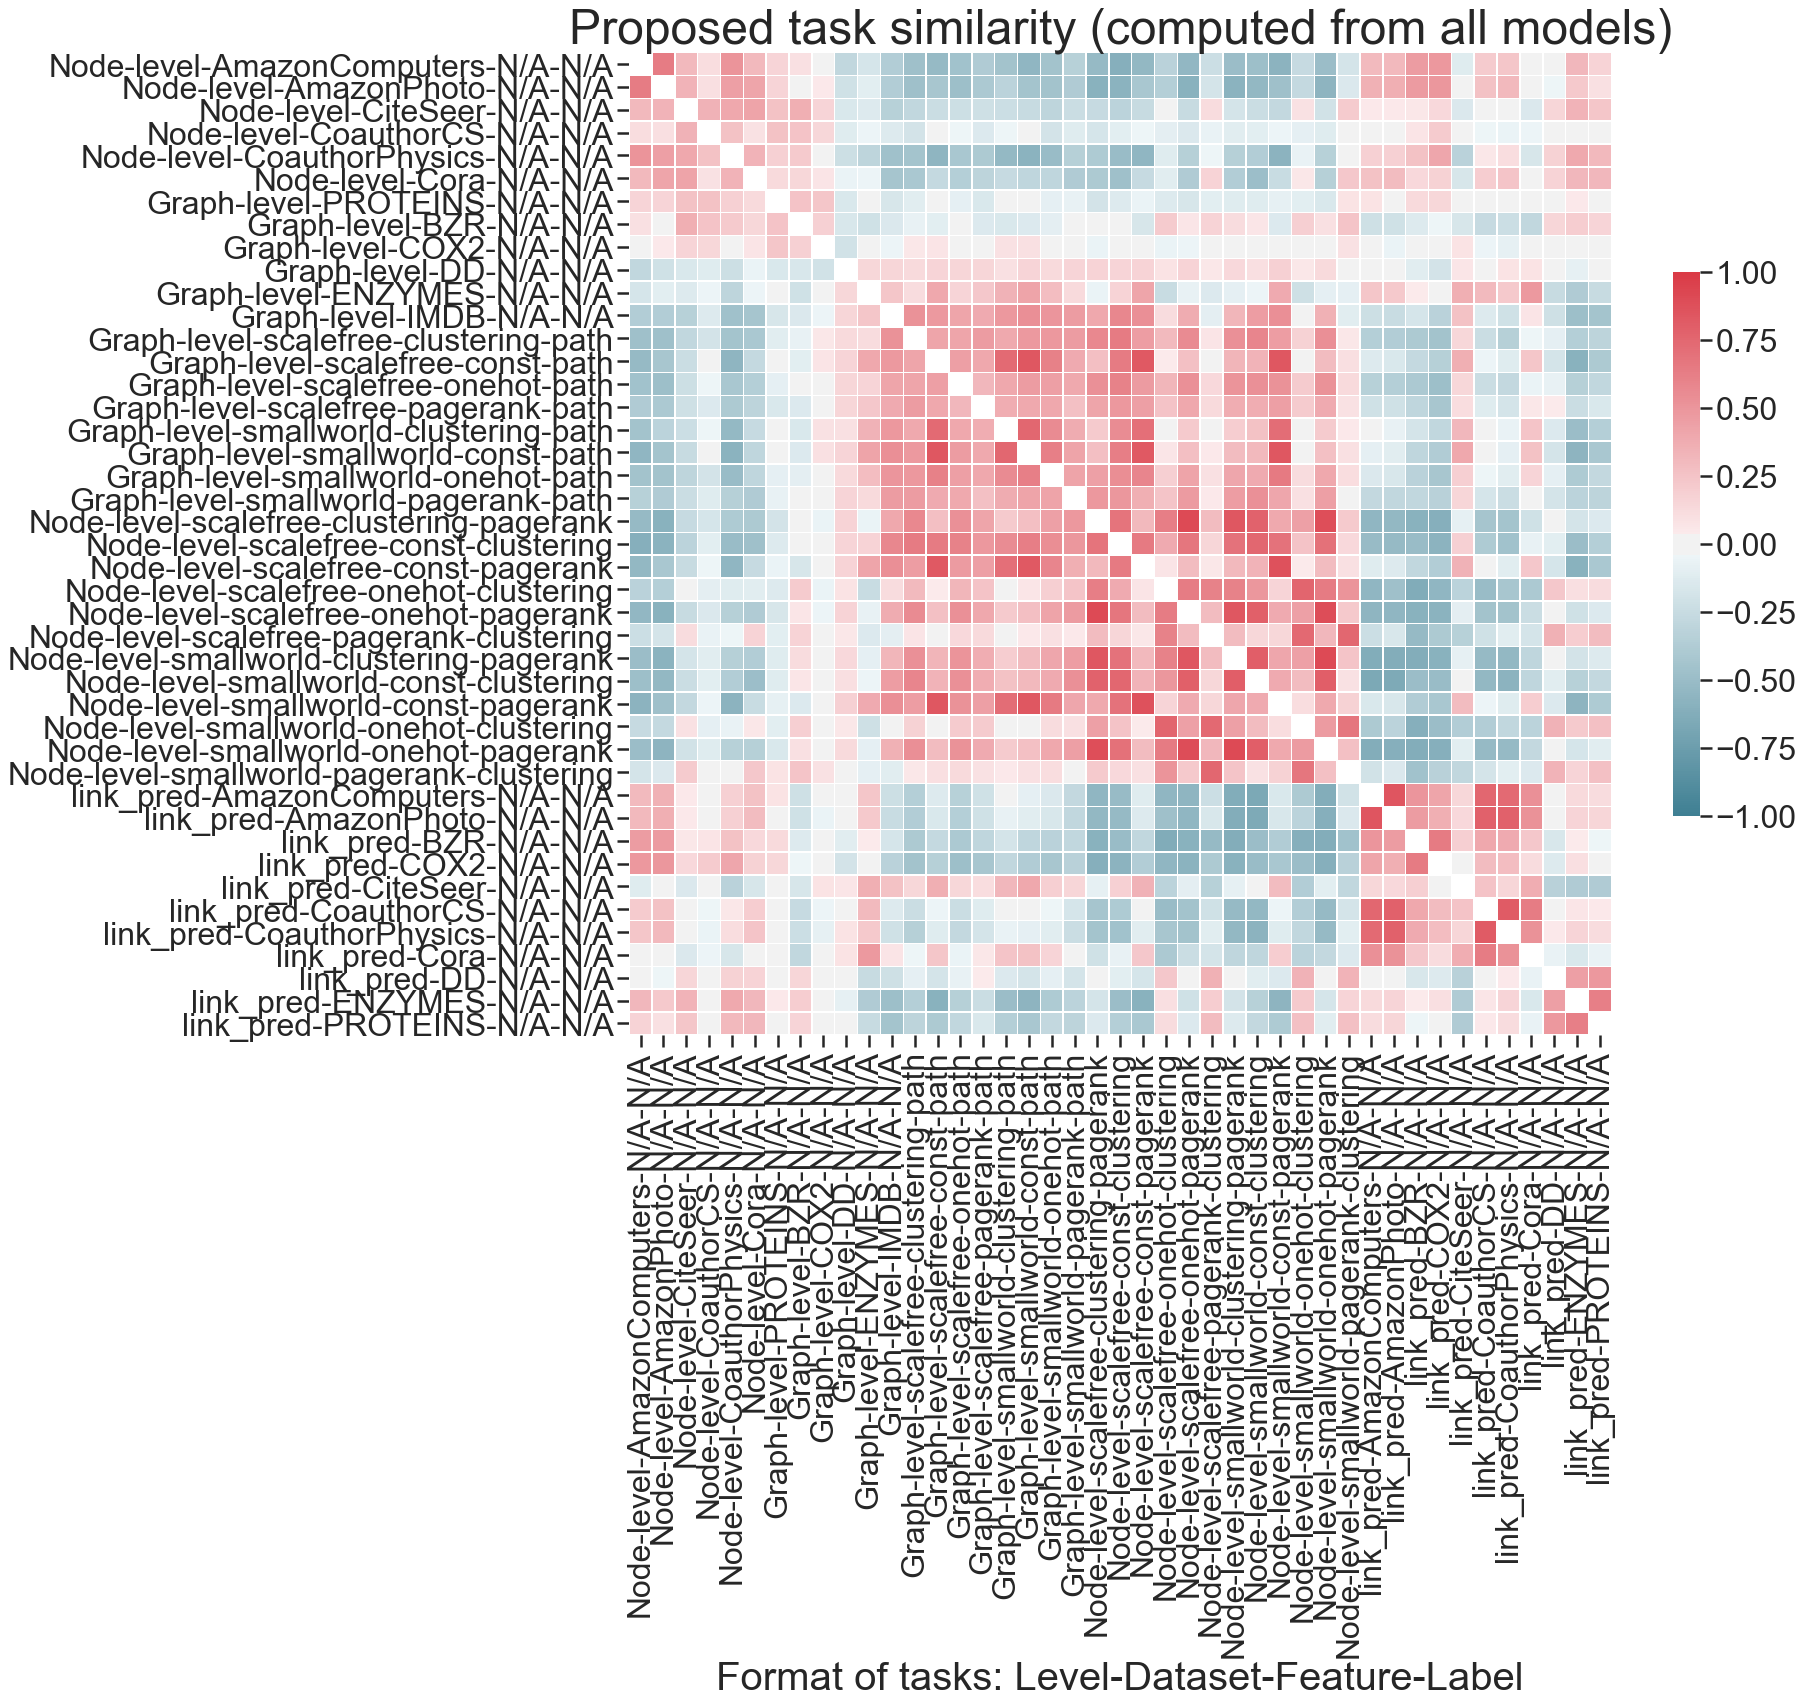

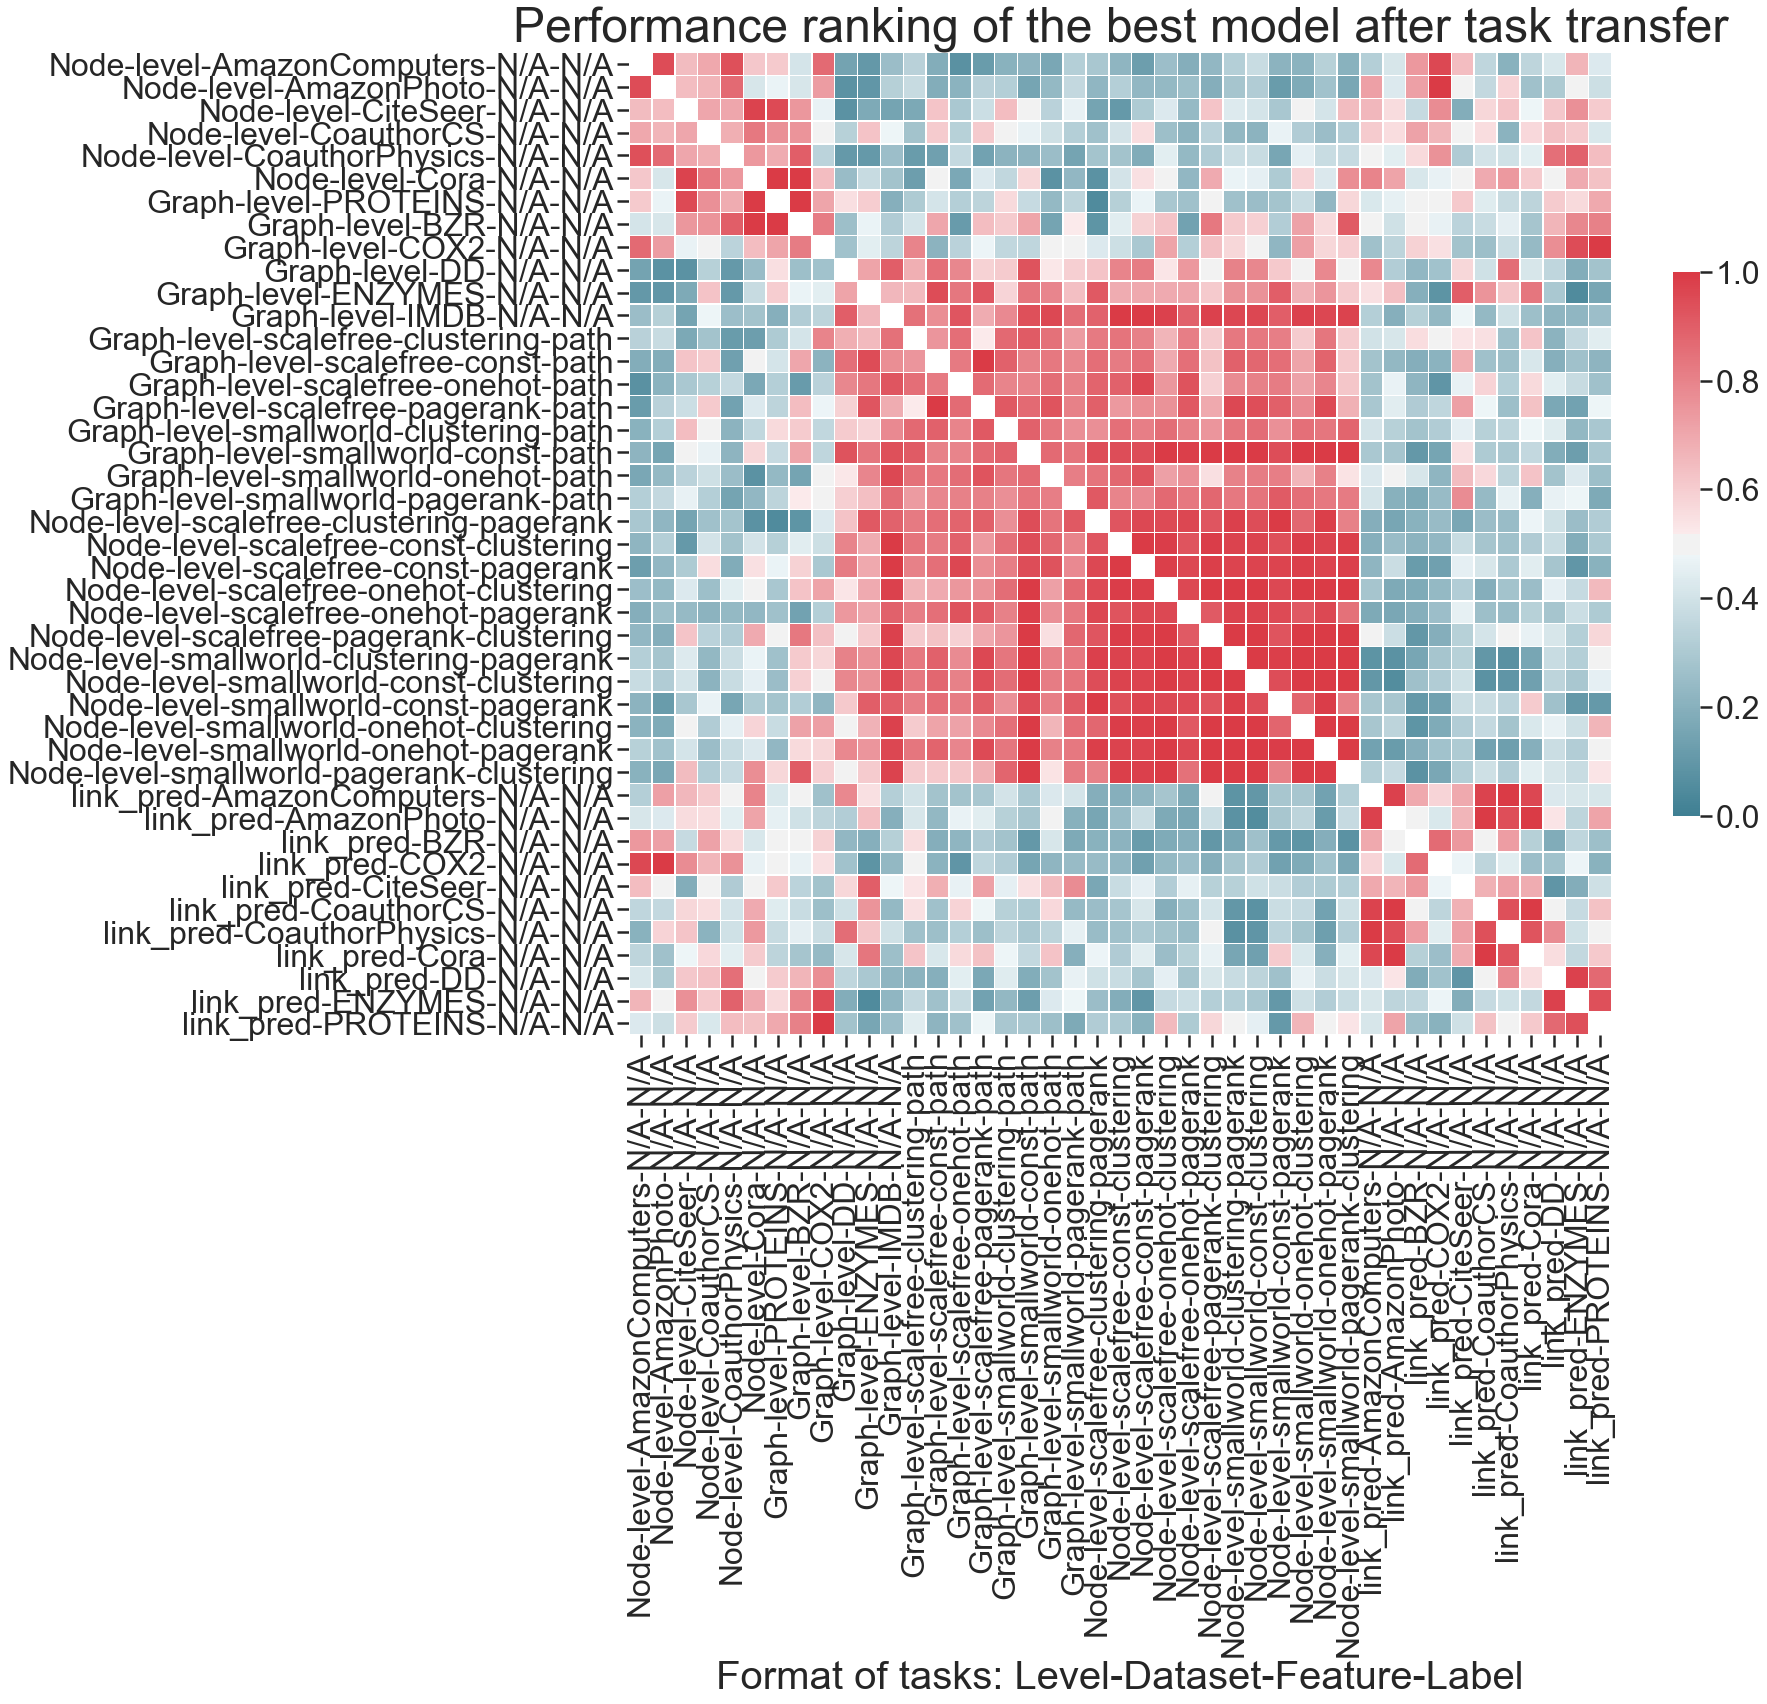

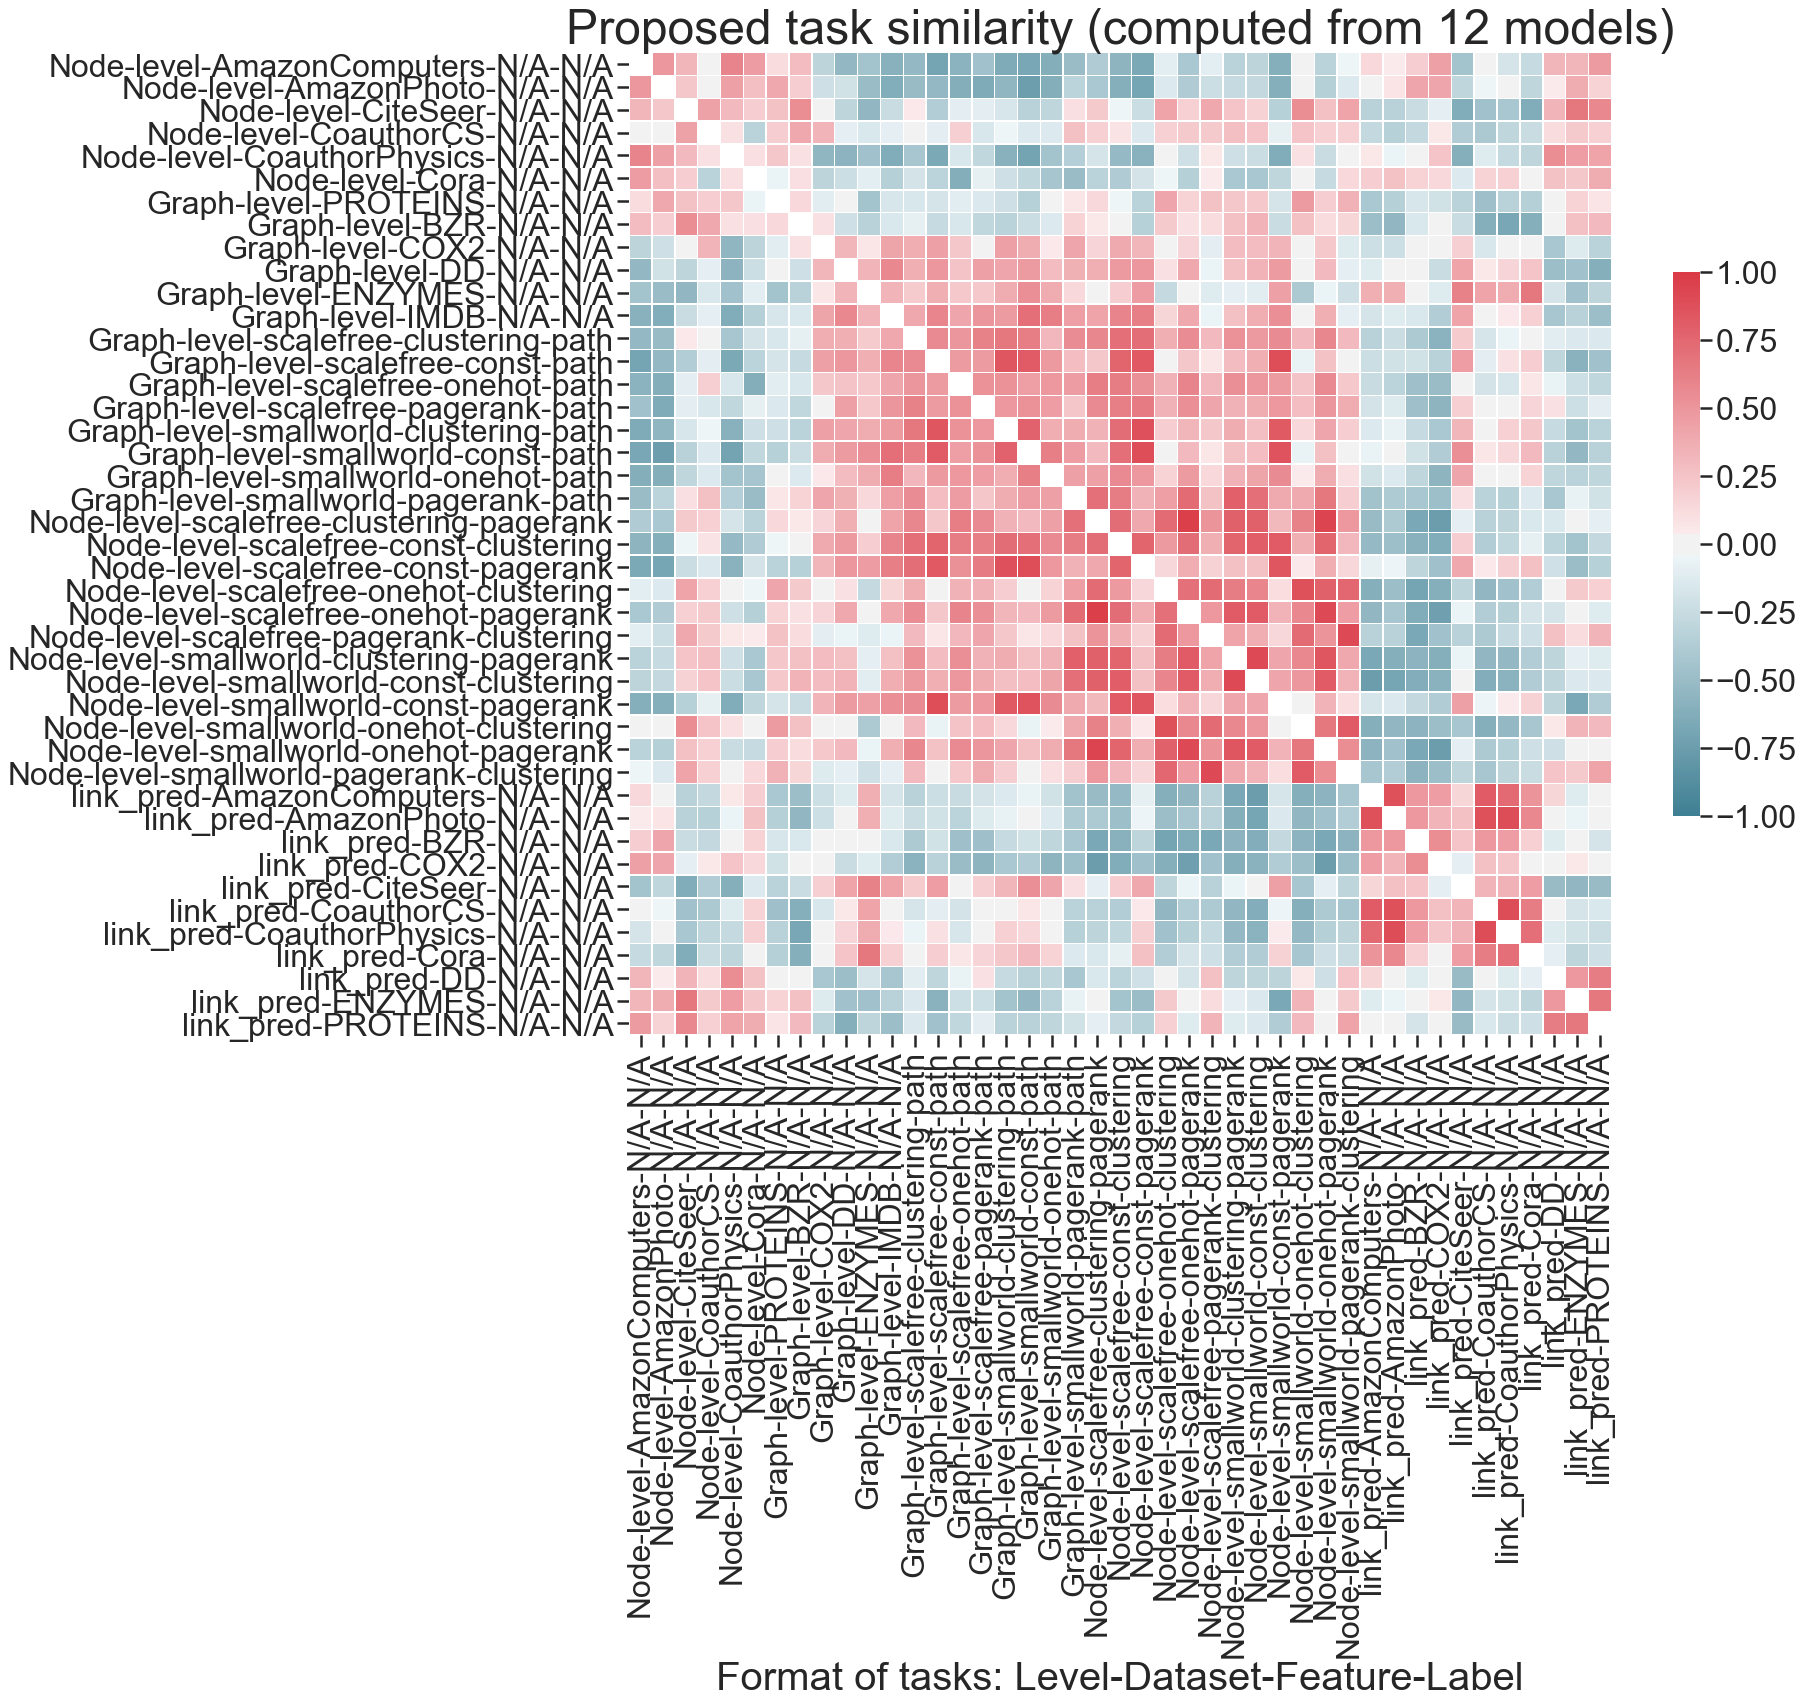

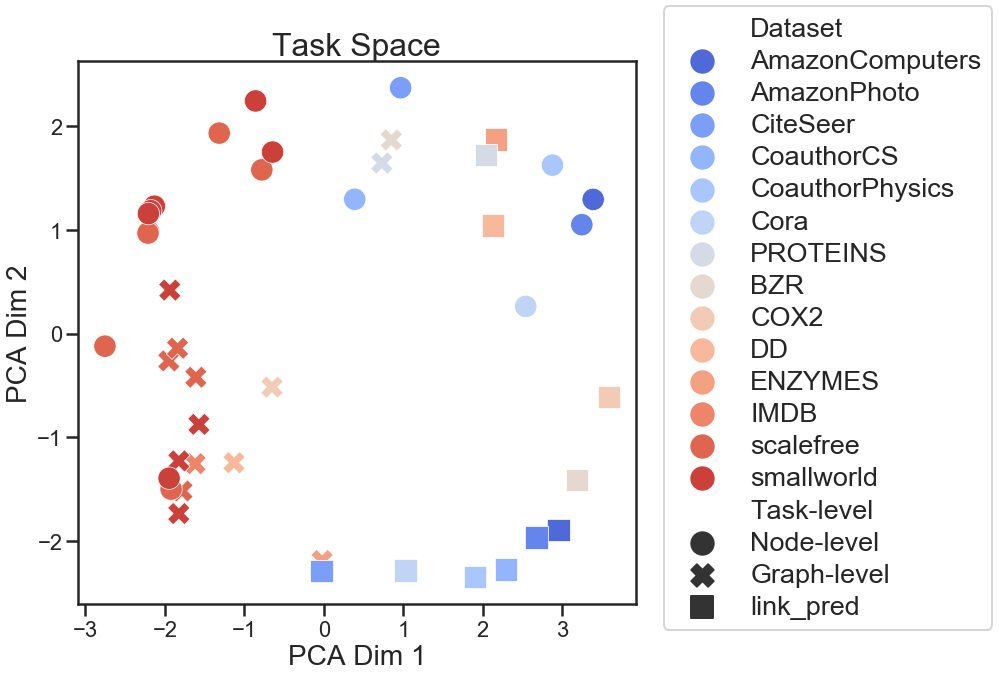

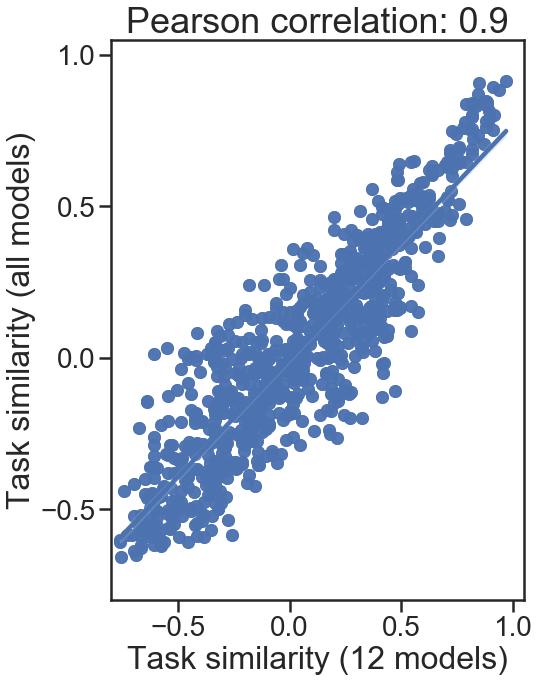

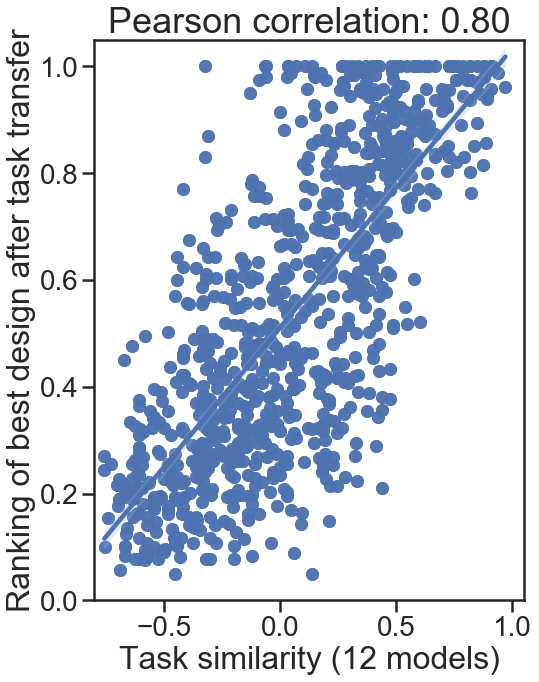

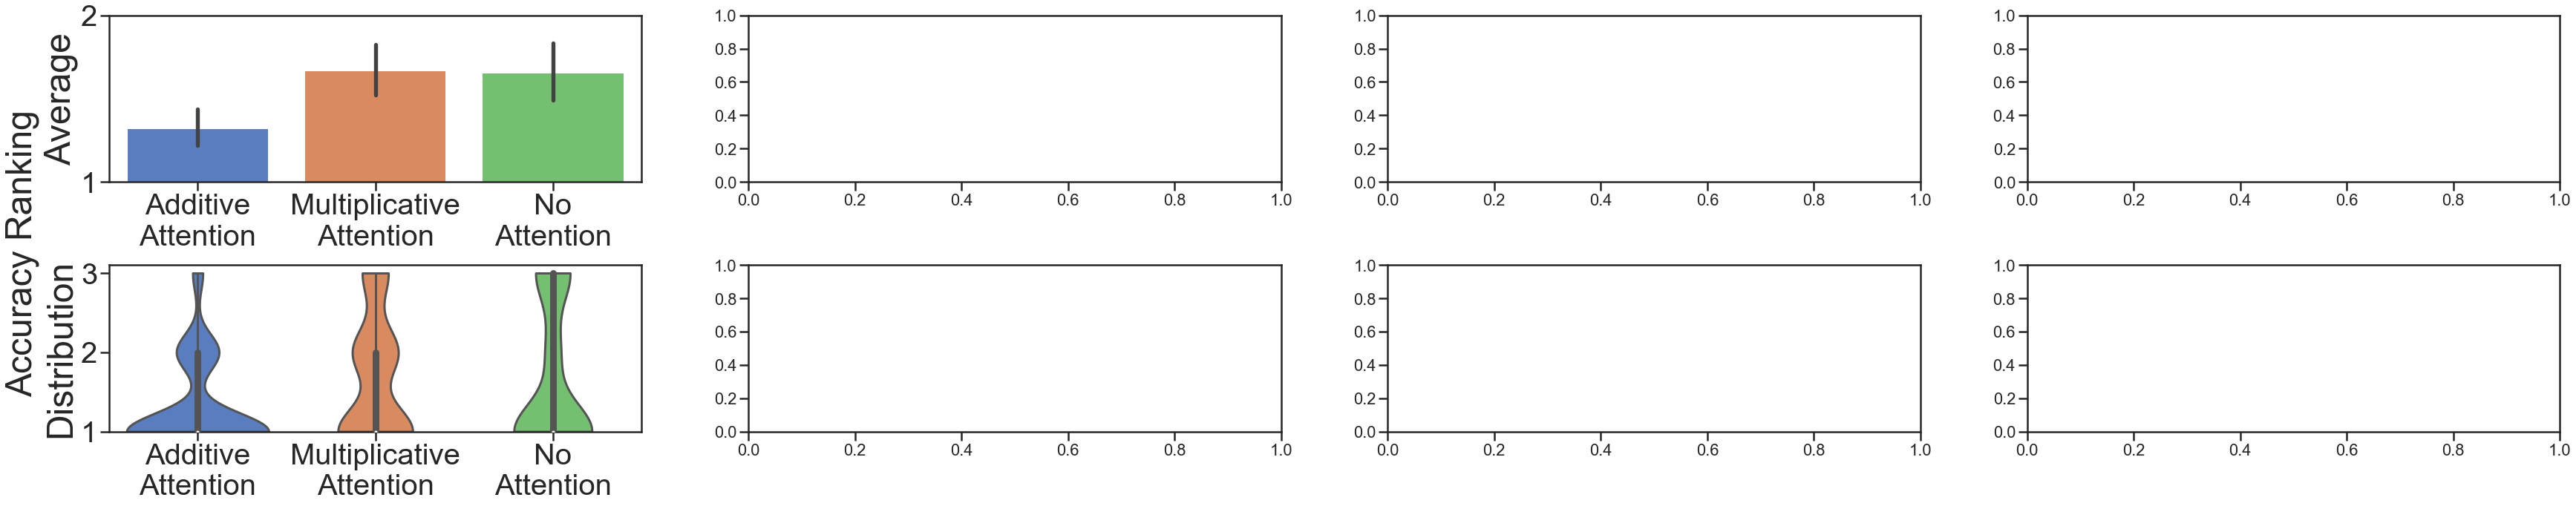

In [23]:
# (6 Appendix) Case study: study new design dimension
# We explore different types of graph attention
# We find that Additive Attention performs the best
# Appendix Figure in "Design Space for Graph Neural Networks"

from scipy.stats import rankdata
from matplotlib.ticker import MaxNLocator

results_file_path = '../run/results/design_v1_grid_round1att/agg/val.csv'
df = pd.read_csv(results_file_path)
df['epoch'] += 1
df.replace('skipconcat','skipcat',inplace=True)
df.replace('add','sum',inplace=True)
df.replace('gaddconv','Additive\nAttention',inplace=True)
df.replace('generalconv','No\nAttention',inplace=True)
df.replace('gmulconv','Multiplicative\nAttention',inplace=True)



name_mapping = {'act': 'Activation', 'bn':'Batch Normalization', 'drop':'Dropout', 'agg':'Aggregation',
                'l_mp':'Message passing layers', 'l_pre':'Pre-process layers', 'l_post': 'Post-process layers', 'stage': 'Layer connectivity',
                'l_t': 'Attention', 'lr': 'Learning rate', 'batch':'Batch size', 'optim': 'Optimizer', 'epoch': 'Training epochs'}

column = ['sample', 'format', 'dataset', 'task', 'trans', 'feature', 'label',
       'l_t', 'l_pre', 'l_mp', 'l_post', 'stage', 'bn', 'act', 'drop', 'agg',
       'optim', 'lr', 'epoch']

def get_acc(df, name, ax, metric='acc', has_y=True):
    df_selected = df[df['sample']==name].copy()
    df_selected[column] = df_selected[column].fillna('Nan')

    column_temp = copy.deepcopy(column)
    column_temp.remove(name)
    df_pivot = pd.pivot_table(df_selected, values='accuracy', index=column_temp, columns=[name], aggfunc=np.mean)
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(2)
    options = df_pivot.columns.values
        
    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name_mapping[name]:[]}
    
    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row; (2) rank start with 1 so we minus 1
        rank_base = -row
        med = np.median(rank_base)
        bias = 0.021
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= bias:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping[name]].append(options[j])
    
    ranks_raw = pd.DataFrame(data=ranks_raw)     
    with sns.color_palette("muted"):
        if metric=='acc':
            splot = sns.violinplot(x=name_mapping[name], y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
        elif metric=='rank_bar':
            splot = sns.barplot(x=name_mapping[name], y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Average',fontsize=48)
        elif metric=='rank_violin':
            sns.violinplot(x=name_mapping[name], y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_xlabel('',fontsize=48)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Distribution',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        

for names in [['l_t']]:
    col = 4
    row = 2
    f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 10))
    

    for j,metric in enumerate(['rank_bar','rank_violin']):
        for i,name in enumerate(names):
            get_acc(df, name, axes[j, i], metric, has_y=i==0)
    f.text(-0.001, 0.5, 'Accuracy Ranking', ha='center', va='center', rotation='vertical', fontsize=48)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.5)    
    plt.show()

